### Removendo as sources que sao repetidas (ex: ac-am e am-ac) - deixa apenas uma 
### Rmovendo rolling mean e linear interpoaltion

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def identificar_links_duplicados(data):
    """
    Identifica links duplicados (ex: ac-am e am-ac) e seleciona o melhor
    baseado no critério: melhor NRMSE do Stacking, depois melhor R²
    """
    print("IDENTIFICANDO E SELECIONANDO LINKS UNICOS...")
    print("=" * 60)
    
    # Criar dicionário para agrupar links duplicados
    links_agrupados = {}
    
    for link in data.keys():
        # Criar chave normalizada (ordenar os nós)
        nodes = link.split('-')
        key = '-'.join(sorted(nodes))
        
        if key not in links_agrupados:
            links_agrupados[key] = []
        links_agrupados[key].append(link)
    
    # Identificar links com duplicatas
    links_duplicados = {k: v for k, v in links_agrupados.items() if len(v) > 1}
    links_unicos = {k: v[0] for k, v in links_agrupados.items() if len(v) == 1}
    
    print(f"ESTATISTICAS DE LINKS:")
    print(f"   Total de links originais: {len(data)}")
    print(f"   Grupos de links unicos: {len(links_agrupados)}")
    print(f"   Links com duplicatas: {len(links_duplicados)}")
    print(f"   Links unicos: {len(links_unicos)}")
    
    # Selecionar o melhor link de cada grupo duplicado
    links_selecionados = {}
    
    for grupo, links in links_duplicados.items():
        print(f"\nGRUPO {grupo}: {links}")
        
        melhor_link = None
        melhor_nrmse = float('inf')
        melhor_r2 = -float('inf')
        
        for link in links:
            # Calcular média do NRMSE e R² do Stacking para este link
            nrmse_values = []
            r2_values = []
            
            for missing_rate, methods in data[link].items():
                stacking_metrics = methods['stacking']['mean']['StackingRegressor']
                if stacking_metrics['nrmse'] is not None:
                    nrmse_values.append(stacking_metrics['nrmse'])
                if stacking_metrics['r2'] is not None:
                    r2_values.append(stacking_metrics['r2'])
            
            if nrmse_values and r2_values:
                avg_nrmse = np.mean(nrmse_values)
                avg_r2 = np.mean(r2_values)
                
                print(f"   {link}: NRMSE={avg_nrmse:.2f}, R2={avg_r2:.3f}")
                
                # Critério de seleção: primeiro NRMSE, depois R²
                if (avg_nrmse < melhor_nrmse) or (avg_nrmse == melhor_nrmse and avg_r2 > melhor_r2):
                    melhor_link = link
                    melhor_nrmse = avg_nrmse
                    melhor_r2 = avg_r2
        
        if melhor_link:
            links_selecionados[grupo] = melhor_link
            print(f"   SELECIONADO: {melhor_link} (NRMSE: {melhor_nrmse:.2f}, R2: {melhor_r2:.3f})")
        else:
            # Se nenhum tem métricas válidas, seleciona o primeiro
            links_selecionados[grupo] = links[0]
            print(f"   SELECIONADO: {links[0]} (sem metricas validas)")
    
    # Adicionar links únicos
    for grupo, link in links_unicos.items():
        links_selecionados[grupo] = link
    
    # Criar novo dicionário com dados filtrados
    data_filtrado = {}
    for grupo, link in links_selecionados.items():
        data_filtrado[link] = data[link]
    
    print(f"\nRESULTADO DA SELECAO:")
    print(f"   Links originais: {len(data)}")
    print(f"   Links apos filtro: {len(data_filtrado)}")
    print(f"   Reducao: {len(data) - len(data_filtrado)} links removidos")
    
    # Salvar lista de links selecionados (SEM EMOJIS)
    with open('links_selecionados_analise.txt', 'w', encoding='utf-8') as f:
        f.write("LINKS SELECIONADOS PARA ANALISE FINAL\n")
        f.write("=" * 50 + "\n")
        f.write(f"Total: {len(data_filtrado)} links\n\n")
        
        # Escrever grupos com duplicatas
        if links_duplicados:
            f.write("GRUPOS COM DUPLICATAS (apenas o selecionado):\n")
            for grupo, links in links_duplicados.items():
                selecionado = links_selecionados[grupo]
                f.write(f"  {grupo}:\n")
                for link in links:
                    if link == selecionado:
                        f.write(f"    [SELECTED] {link}\n")
                    else:
                        f.write(f"    [REMOVED]  {link}\n")
                f.write("\n")
        
        # Escrever links únicos
        f.write("LINKS UNICOS:\n")
        for grupo, link in links_unicos.items():
            f.write(f"  [UNIQUE] {link}\n")
    
    return data_filtrado, links_selecionados

def final_robust_analysis(json_file_path):
    """Análise final robusta - removendo outliers extremos e selecionando links únicos"""
    
    # Carregar dados
    with open(json_file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # FASE 1: SELECIONAR LINKS ÚNICOS
    data_filtrado, links_selecionados = identificar_links_duplicados(data)
    
    # FASE 2: PROCESSAR DADOS COM LINKS SELECIONADOS
    records = []
    all_sources = set()
    
    for link, missing_data in data_filtrado.items():
        all_sources.add(link)
        for missing_rate, methods in missing_data.items():
            missing_rate_float = float(missing_rate)
            
            for method_name, metrics in methods['baseline'].items():
                records.append({
                    'link': link, 'missing_rate': missing_rate_float,
                    'method_type': 'baseline', 'method': method_name,
                    'rmse': metrics['rmse'], 'nrmse': metrics['nrmse'],
                    'r2': metrics['r2'], 'mape': metrics['mape']
                })
            
            stacking_metrics = methods['stacking']['mean']['StackingRegressor']
            records.append({
                'link': link, 'missing_rate': missing_rate_float,
                'method_type': 'stacking', 'method': 'StackingRegressor',
                'rmse': stacking_metrics['rmse'], 'nrmse': stacking_metrics['nrmse'],
                'r2': stacking_metrics['r2'], 'mape': stacking_metrics['mape']
            })
    
    df = pd.DataFrame(records)
    
    print("\nANALISE FINAL ROBUSTA - RESULTADOS CONFIAVEIS")
    print("=" * 80)
    
    # ESTATÍSTICAS INICIAIS DO DATASET
    print(f"\nESTATISTICAS DO DATASET (APOS FILTRAGEM):")
    print(f"   Fontes de dados unicas: {len(all_sources)}")
    print(f"   Configuracoes totais (antes da limpeza): {len(df)}")
    print(f"   Metodos comparados: {len(df['method'].unique())}")
    print(f"   Taxas de missing testadas: {sorted(df['missing_rate'].unique())}")
    
    # REMOVER OUTLIERS EXTREMOS
    print("\nFILTRANDO OUTLIERS EXTREMOS...")
    
    df_clean = df.copy()
    
    # Critérios de outliers
    mape_threshold = 1000
    r2_threshold = -10
    rmse_threshold = 1000
    
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['mape'] <= mape_threshold]
    df_clean = df_clean[df_clean['r2'] >= r2_threshold]
    df_clean = df_clean[df_clean['rmse'] <= rmse_threshold]
    
    removed_count = initial_count - len(df_clean)
    print(f"Removidos {removed_count} registros problematicos ({removed_count/initial_count*100:.1f}%)")
    
    # ESTATÍSTICAS FINAIS COMPLETAS
    print("\nESTATISTICAS FINAIS COMPLETAS (Dados Limpos):")
    print("-" * 60)
    
    metrics = ['rmse', 'nrmse', 'r2', 'mape']
    summary_data = []
    
    for method in df_clean['method'].unique():
        method_data = df_clean[df_clean['method'] == method]
        row = {'method': method, 'count': len(method_data)}
        
        for metric in metrics:
            values = method_data[metric]
            row[f'{metric}_mean'] = values.mean()
            row[f'{metric}_std'] = values.std()
            row[f'{metric}_median'] = values.median()
            row[f'{metric}_min'] = values.min()
            row[f'{metric}_max'] = values.max()
            row[f'{metric}_q1'] = values.quantile(0.25)
            row[f'{metric}_q3'] = values.quantile(0.75)
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calcular ranking por métrica
    for metric in metrics:
        if metric == 'r2':
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=False)
        else:
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=True)
    
    # Ranking geral
    rank_columns = [f'{metric}_rank' for metric in metrics]
    summary_df['overall_rank'] = summary_df[rank_columns].mean(axis=1)
    summary_df = summary_df.sort_values('overall_rank')
    
    print("\n" + "=" * 80)
    print("RANKING FINAL - DADOS LIMPOS")
    print("=" * 80)
    
    for i, (_, row) in enumerate(summary_df.iterrows(), 1):
        print(f"{i:2d}. {row['method']:20s} | "
              f"RMSE: {row['rmse_mean']:6.2f} | "
              f"NRMSE: {row['nrmse_mean']:5.2f} | "
              f"R2: {row['r2_mean']:6.3f} | "
              f"MAPE: {row['mape_mean']:6.2f}%")
    
    # ANÁLISE POR LINK (para verificar performance individual)
    print("\n" + "=" * 80)
    print("DESEMPENHO DO STACKING POR LINK")
    print("=" * 80)
    
    link_performance = []
    for link in sorted(all_sources):
        link_data = df_clean[df_clean['link'] == link]
        stacking_data = link_data[link_data['method'] == 'StackingRegressor']
        
        if len(stacking_data) > 0:
            avg_nrmse = stacking_data['nrmse'].mean()
            avg_r2 = stacking_data['r2'].mean()
            link_performance.append({
                'link': link,
                'nrmse': avg_nrmse,
                'r2': avg_r2,
                'samples': len(stacking_data)
            })
    
    # Ordenar por NRMSE (menor é melhor)
    link_performance.sort(key=lambda x: x['nrmse'])
    
    print("\nTop 10 melhores links por NRMSE do Stacking:")
    print("Link      | NRMSE  |   R2   | Amostras")
    print("-" * 40)
    for perf in link_performance[:10]:
        print(f"{perf['link']:9} | {perf['nrmse']:6.2f} | {perf['r2']:6.3f} | {perf['samples']:8}")
    
    print(f"\nLISTA COMPLETA DE LINKS SELECIONADOS:")
    print(f"   Salva em: 'links_selecionados_analise.txt'")
    print(f"   Total de links na analise: {len(all_sources)}")
    
    # GRÁFICOS FINAIS - REMOVENDO ROLLINGMEAN E LINEARINTERPOLATION
    print("\nGERANDO GRAFICOS FINAIS...")
    
    # 1. Comparação direta Stacking vs BASELINES SELECIONADAS
    # Métodos que vamos manter: Stacking + Mean, Median, KNNImputer, ForwardFill, BackwardFill
    metodos_selecionados = ['StackingRegressor', 'Mean', 'Median', 'KNNImputer', 'ForwardFill', 'BackwardFill']
    
    comparison_data = []
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            comparison_data.append({
                'method': method,
                'rmse': method_data['rmse'].mean(),
                'nrmse': method_data['nrmse'].mean(),
                'r2': method_data['r2'].mean(),
                'mape': method_data['mape'].mean()
            })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Plot com MÉTODOS SELECIONADOS
    metrics_for_plot = ['rmse', 'nrmse', 'mape']
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for idx, metric in enumerate(metrics_for_plot + ['r2']):
        if metric == 'r2':
            # Para R², maior é melhor - ordenar descendente
            sorted_df = comp_df.sort_values(metric, ascending=False)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        else:
            # Para outras métricas, menor é melhor - ordenar ascendente
            sorted_df = comp_df.sort_values(metric, ascending=True)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        
        bars = axes[idx//2, idx%2].bar(range(len(sorted_df)), sorted_df[metric], color=colors, alpha=0.7)
        # axes[idx//2, idx%2].set_title(f'Comparacao de {metric.upper()}\n(Verde = Stacking)', fontweight='bold', fontsize=12)
        axes[idx//2, idx%2].set_ylabel(metric.upper(), fontsize=11)
        axes[idx//2, idx%2].set_xticks(range(len(sorted_df)))
        axes[idx//2, idx%2].set_xticklabels(sorted_df['method'], rotation=45, ha='right', fontsize=10)
        
        for bar, value in zip(bars, sorted_df[metric]):
            height = bar.get_height()
            axes[idx//2, idx%2].text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                          f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('comparacao_final_links_unicos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Performance por taxa de missing (APENAS MÉTODOS SELECIONADOS)
    print("\nPERFORMANCE POR TAXA DE MISSING (METODOS SELECIONADOS)...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Cores distintas para cada método selecionado
    colors = plt.cm.Set3(np.linspace(0, 1, len(metodos_selecionados)))
    color_map = {method: color for method, color in zip(metodos_selecionados, colors)}
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        for method in metodos_selecionados:
            method_data = df_clean[df_clean['method'] == method]
            if len(method_data) > 0:
                performance_by_missing = method_data.groupby('missing_rate')[metric].mean().sort_index()
                
                # Usar cor vermelha para Stacking, outras cores para baselines
                color = 'red' if method == 'StackingRegressor' else color_map[method]
                linewidth = 3 if method == 'StackingRegressor' else 2
                linestyle = '-' if method == 'StackingRegressor' else '--'
                
                ax.plot(performance_by_missing.index, performance_by_missing.values, 
                       marker='o', linewidth=linewidth, label=method, 
                       markersize=5, color=color, linestyle=linestyle)
        
        # ax.set_title(f'Evolucao do {metric.upper()} com Missing Data', fontweight='bold', fontsize=12)
        ax.set_xlabel('Taxa de Missing Data', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evolucao_missing_metodos_selecionados.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Boxplot comparativo (APENAS MÉTODOS SELECIONADOS)
    print("\nBOXPLOT COMPARATIVO (METODOS SELECIONADOS)...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        # Filtrar apenas métodos selecionados
        df_selected = df_clean[df_clean['method'].isin(metodos_selecionados)]
        
        # Ordenar métodos pela mediana
        method_order = df_selected.groupby('method')[metric].median().sort_values().index
        
        sns.boxplot(data=df_selected, x='method', y=metric, ax=ax, order=method_order)
        # ax.set_title(f'Distribuicao de {metric.upper()} - Metodos Selecionados', fontweight='bold', fontsize=12)
        ax.set_xlabel('Metodo', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        
        # Destacar Stacking
        for i, artist in enumerate(ax.artists):
            if method_order[i] == 'StackingRegressor':
                artist.set_facecolor('lightgreen')
                artist.set_edgecolor('darkgreen')
                artist.set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('boxplot_metodos_selecionados.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # RESUMO FINAL
    print("\n" + "=" * 80)
    print("RESUMO PARA ARTIGO CIENTIFICO")
    print("=" * 80)
    
    stacking_data = df_clean[df_clean['method'] == 'StackingRegressor']
    best_baseline_data = df_clean[df_clean['method'] == summary_df.iloc[1]['method']]
    
    print(f"\nMETODOLOGIA EXPERIMENTAL:")
    print(f"   Fontes de dados unicas: {len(all_sources)}")
    print(f"   Links duplicados removidos: {len(data) - len(data_filtrado)}")
    print(f"   Metodos comparados: {len(metodos_selecionados)}")
    print(f"   Configuracoes validas analisadas: {len(df_clean)}")
    
    print(f"\nMELHOR BASELINE: {summary_df.iloc[1]['method']}")
    
    print(f"\nCOMPARACAO ESTATISTICA DETALHADA:")
    print(f"\nRMSE: {stacking_data['rmse'].mean():.2f} vs {best_baseline_data['rmse'].mean():.2f} ({(1 - stacking_data['rmse'].mean()/best_baseline_data['rmse'].mean())*100:.1f}% melhor)")
    print(f"NRMSE: {stacking_data['nrmse'].mean():.2f} vs {best_baseline_data['nrmse'].mean():.2f} ({(1 - stacking_data['nrmse'].mean()/best_baseline_data['nrmse'].mean())*100:.1f}% melhor)")
    print(f"R2: {stacking_data['r2'].mean():.3f} vs {best_baseline_data['r2'].mean():.3f} ({(stacking_data['r2'].mean() - best_baseline_data['r2'].mean()):.3f} pontos melhor)")
    
    # Salvar dados finais
    df_clean.to_csv('dados_limpos_links_unicos.csv', index=False)
    summary_df.to_csv('estatisticas_links_unicos.csv', index=False)
    
    print(f"\nARQUIVOS SALVOS:")
    print(f"   - 'dados_limpos_links_unicos.csv'")
    print(f"   - 'estatisticas_links_unicos.csv'")
    print(f"   - 'links_selecionados_analise.txt' (lista completa)")
    print(f"   - 'comparacao_final_links_unicos.png' (grafico comparativo)")
    print(f"   - 'evolucao_missing_metodos_selecionados.png' (evolucao)")
    print(f"   - 'boxplot_metodos_selecionados.png' (boxplot)")
    print(f"Total de registros validos: {len(df_clean)}")

# Executar análise final
json_file_path = "../../results/metrics_summary_complete.json"
final_robust_analysis(json_file_path)

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Configurações de fonte parametrizáveis
FONT_CONFIG = {
    'method_names': 14,      # Tamanho da fonte para nomes dos métodos
    'axis_labels': 16,       # Tamanho da fonte para labels dos eixos
    'axis_values': 14,       # Tamanho da fonte para valores dos eixos
    'bar_values': 12,        # Tamanho da fonte para valores nas barras
    'legend': 12,            # Tamanho da fonte para legenda
    'title': 18              # Tamanho da fonte para títulos (se necessário)
}

def identificar_links_duplicados(data):
    """
    Identifica links duplicados (ex: ac-am e am-ac) e seleciona o melhor
    baseado no critério: melhor NRMSE do Stacking, depois melhor R²
    """
    print("IDENTIFYING AND SELECTING UNIQUE LINKS...")
    print("=" * 60)
    
    # Criar dicionário para agrupar links duplicados
    links_agrupados = {}
    
    for link in data.keys():
        # Criar chave normalizada (ordenar os nós)
        nodes = link.split('-')
        key = '-'.join(sorted(nodes))
        
        if key not in links_agrupados:
            links_agrupados[key] = []
        links_agrupados[key].append(link)
    
    # Identificar links com duplicatas
    links_duplicados = {k: v for k, v in links_agrupados.items() if len(v) > 1}
    links_unicos = {k: v[0] for k, v in links_agrupados.items() if len(v) == 1}
    
    print(f"LINK STATISTICS:")
    print(f"   Total original links: {len(data)}")
    print(f"   Unique link groups: {len(links_agrupados)}")
    print(f"   Links with duplicates: {len(links_duplicados)}")
    print(f"   Unique links: {len(links_unicos)}")
    
    # Selecionar o melhor link de cada grupo duplicado
    links_selecionados = {}
    
    for grupo, links in links_duplicados.items():
        print(f"\nGROUP {grupo}: {links}")
        
        melhor_link = None
        melhor_nrmse = float('inf')
        melhor_r2 = -float('inf')
        
        for link in links:
            # Calcular média do NRMSE e R² do Stacking para este link
            nrmse_values = []
            r2_values = []
            
            for missing_rate, methods in data[link].items():
                stacking_metrics = methods['stacking']['mean']['StackingRegressor']
                if stacking_metrics['nrmse'] is not None:
                    nrmse_values.append(stacking_metrics['nrmse'])
                if stacking_metrics['r2'] is not None:
                    r2_values.append(stacking_metrics['r2'])
            
            if nrmse_values and r2_values:
                avg_nrmse = np.mean(nrmse_values)
                avg_r2 = np.mean(r2_values)
                
                print(f"   {link}: NRMSE={avg_nrmse:.2f}, R2={avg_r2:.3f}")
                
                # Critério de seleção: primeiro NRMSE, depois R²
                if (avg_nrmse < melhor_nrmse) or (avg_nrmse == melhor_nrmse and avg_r2 > melhor_r2):
                    melhor_link = link
                    melhor_nrmse = avg_nrmse
                    melhor_r2 = avg_r2
        
        if melhor_link:
            links_selecionados[grupo] = melhor_link
            print(f"   SELECTED: {melhor_link} (NRMSE: {melhor_nrmse:.2f}, R2: {melhor_r2:.3f})")
        else:
            # Se nenhum tem métricas válidas, seleciona o primeiro
            links_selecionados[grupo] = links[0]
            print(f"   SELECTED: {links[0]} (no valid metrics)")
    
    # Adicionar links únicos
    for grupo, link in links_unicos.items():
        links_selecionados[grupo] = link
    
    # Criar novo dicionário com dados filtrados
    data_filtrado = {}
    for grupo, link in links_selecionados.items():
        data_filtrado[link] = data[link]
    
    print(f"\nSELECTION RESULT:")
    print(f"   Original links: {len(data)}")
    print(f"   Links after filter: {len(data_filtrado)}")
    print(f"   Reduction: {len(data) - len(data_filtrado)} links removed")
    
    # Salvar lista de links selecionados
    with open('links_selecionados_analise.txt', 'w', encoding='utf-8') as f:
        f.write("SELECTED LINKS FOR FINAL ANALYSIS\n")
        f.write("=" * 50 + "\n")
        f.write(f"Total: {len(data_filtrado)} links\n\n")
        
        # Escrever grupos com duplicatas
        if links_duplicados:
            f.write("GROUPS WITH DUPLICATES (only selected):\n")
            for grupo, links in links_duplicados.items():
                selecionado = links_selecionados[grupo]
                f.write(f"  {grupo}:\n")
                for link in links:
                    if link == selecionado:
                        f.write(f"    [SELECTED] {link}\n")
                    else:
                        f.write(f"    [REMOVED]  {link}\n")
                f.write("\n")
        
        # Escrever links únicos
        f.write("UNIQUE LINKS:\n")
        for grupo, link in links_unicos.items():
            f.write(f"  [UNIQUE] {link}\n")
    
    return data_filtrado, links_selecionados

def plot_comparison_final_separado(df_clean, metodos_selecionados):
    """Plot separado: Comparação final entre métodos - UMA FIGURA POR MÉTRICA"""
    print("\nGENERATING SEPARATE COMPARISON PLOTS...")
    
    comparison_data = []
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            comparison_data.append({
                'method': method,
                'rmse': method_data['rmse'].mean(),
                'nrmse': method_data['nrmse'].mean(),
                'r2': method_data['r2'].mean(),
                'mape': method_data['mape'].mean()
            })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Plot RMSE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    sorted_df = comp_df.sort_values('rmse', ascending=True)
    colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
    bars = plt.bar(range(len(sorted_df)), sorted_df['rmse'], color=colors, alpha=0.7)
    plt.ylabel('RMSE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(range(len(sorted_df)), sorted_df['method'], rotation=45, ha='right', 
               fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    for bar, value in zip(bars, sorted_df['rmse']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                f'{value:.2f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=FONT_CONFIG['bar_values'])
    
    plt.tight_layout()
    plt.savefig('comparacao_rmse.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot NRMSE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    sorted_df = comp_df.sort_values('nrmse', ascending=True)
    colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
    bars = plt.bar(range(len(sorted_df)), sorted_df['nrmse'], color=colors, alpha=0.7)
    plt.ylabel('NRMSE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(range(len(sorted_df)), sorted_df['method'], rotation=45, ha='right', 
               fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    for bar, value in zip(bars, sorted_df['nrmse']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                f'{value:.2f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=FONT_CONFIG['bar_values'])
    
    plt.tight_layout()
    plt.savefig('comparacao_nrmse.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot R2 - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    sorted_df = comp_df.sort_values('r2', ascending=False)
    colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
    bars = plt.bar(range(len(sorted_df)), sorted_df['r2'], color=colors, alpha=0.7)
    plt.ylabel('R²', fontsize=FONT_CONFIG['axis_labels'])
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(range(len(sorted_df)), sorted_df['method'], rotation=45, ha='right', 
               fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    for bar, value in zip(bars, sorted_df['r2']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=FONT_CONFIG['bar_values'])
    
    plt.tight_layout()
    plt.savefig('comparacao_r2.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot MAPE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    sorted_df = comp_df.sort_values('mape', ascending=True)
    colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
    bars = plt.bar(range(len(sorted_df)), sorted_df['mape'], color=colors, alpha=0.7)
    plt.ylabel('MAPE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(range(len(sorted_df)), sorted_df['method'], rotation=45, ha='right', 
               fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    for bar, value in zip(bars, sorted_df['mape']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                f'{value:.2f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=FONT_CONFIG['bar_values'])
    
    plt.tight_layout()
    plt.savefig('comparacao_mape.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_evolution_missing_separado(df_clean, metodos_selecionados):
    """Plot separado: Performance por taxa de missing - UMA FIGURA POR MÉTRICA"""
    print("\nGENERATING SEPARATE MISSING RATE EVOLUTION PLOTS...")
    
    # Cores distintas para cada método selecionado
    colors = plt.cm.Set3(np.linspace(0, 1, len(metodos_selecionados)))
    color_map = {method: color for method, color in zip(metodos_selecionados, colors)}
    
    # Plot RMSE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            performance_by_missing = method_data.groupby('missing_rate')['rmse'].mean().sort_index()
            
            # Usar cor vermelha para Stacking, outras cores para baselines
            color = 'red' if method == 'StackingRegressor' else color_map[method]
            linewidth = 3 if method == 'StackingRegressor' else 2
            linestyle = '-' if method == 'StackingRegressor' else '--'
            
            plt.plot(performance_by_missing.index, performance_by_missing.values, 
                    marker='o', linewidth=linewidth, label=method, 
                    markersize=6, color=color, linestyle=linestyle)
    
    plt.xlabel('Missing Rate', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('RMSE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(fontsize=FONT_CONFIG['axis_values'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=FONT_CONFIG['legend'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('evolucao_rmse.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot NRMSE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            performance_by_missing = method_data.groupby('missing_rate')['nrmse'].mean().sort_index()
            
            color = 'red' if method == 'StackingRegressor' else color_map[method]
            linewidth = 3 if method == 'StackingRegressor' else 2
            linestyle = '-' if method == 'StackingRegressor' else '--'
            
            plt.plot(performance_by_missing.index, performance_by_missing.values, 
                    marker='o', linewidth=linewidth, label=method, 
                    markersize=6, color=color, linestyle=linestyle)
    
    plt.xlabel('Missing Rate', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('NRMSE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(fontsize=FONT_CONFIG['axis_values'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=FONT_CONFIG['legend'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('evolucao_nrmse.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot R2 - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            performance_by_missing = method_data.groupby('missing_rate')['r2'].mean().sort_index()
            
            color = 'red' if method == 'StackingRegressor' else color_map[method]
            linewidth = 3 if method == 'StackingRegressor' else 2
            linestyle = '-' if method == 'StackingRegressor' else '--'
            
            plt.plot(performance_by_missing.index, performance_by_missing.values, 
                    marker='o', linewidth=linewidth, label=method, 
                    markersize=6, color=color, linestyle=linestyle)
    
    plt.xlabel('Missing Rate', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('R²', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(fontsize=FONT_CONFIG['axis_values'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=FONT_CONFIG['legend'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('evolucao_r2.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot MAPE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            performance_by_missing = method_data.groupby('missing_rate')['mape'].mean().sort_index()
            
            color = 'red' if method == 'StackingRegressor' else color_map[method]
            linewidth = 3 if method == 'StackingRegressor' else 2
            linestyle = '-' if method == 'StackingRegressor' else '--'
            
            plt.plot(performance_by_missing.index, performance_by_missing.values, 
                    marker='o', linewidth=linewidth, label=method, 
                    markersize=6, color=color, linestyle=linestyle)
    
    plt.xlabel('Missing Rate', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('MAPE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(fontsize=FONT_CONFIG['axis_values'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=FONT_CONFIG['legend'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('evolucao_mape.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# def plot_boxplot_comparison_separado(df_clean, metodos_selecionados):
#     """Plot separado: Boxplot comparativo - UMA FIGURA POR MÉTRICA"""
#     print("\nGENERATING SEPARATE BOXPLOTS...")
    
#     # Filtrar apenas métodos selecionados
#     df_selected = df_clean[df_clean['method'].isin(metodos_selecionados)]
    
#     # Plot RMSE - SEPARATE FIGURE
#     plt.figure(figsize=(12, 8))
#     method_order = df_selected.groupby('method')['rmse'].median().sort_values().index
#     sns.boxplot(data=df_selected, x='method', y='rmse', order=method_order)
#     plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
#     plt.ylabel('RMSE', fontsize=FONT_CONFIG['axis_labels'])
#     plt.xticks(rotation=45, fontsize=FONT_CONFIG['method_names'])
#     plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
#     # Destacar Stacking
#     ax = plt.gca()
#     for i, artist in enumerate(ax.artists):
#         if method_order[i] == 'StackingRegressor':
#             artist.set_facecolor('lightgreen')
#             artist.set_edgecolor('darkgreen')
#             artist.set_linewidth(2)
    
#     plt.tight_layout()
#     plt.savefig('boxplot_rmse.png', dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close()
    
#     # Plot NRMSE - SEPARATE FIGURE
#     plt.figure(figsize=(12, 8))
#     method_order = df_selected.groupby('method')['nrmse'].median().sort_values().index
#     sns.boxplot(data=df_selected, x='method', y='nrmse', order=method_order)
#     plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
#     plt.ylabel('NRMSE', fontsize=FONT_CONFIG['axis_labels'])
#     plt.xticks(rotation=45, fontsize=FONT_CONFIG['method_names'])
#     plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
#     # Destacar Stacking
#     ax = plt.gca()
#     for i, artist in enumerate(ax.artists):
#         if method_order[i] == 'StackingRegressor':
#             artist.set_facecolor('lightgreen')
#             artist.set_edgecolor('darkgreen')
#             artist.set_linewidth(2)
    
#     plt.tight_layout()
#     plt.savefig('boxplot_nrmse.png', dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close()
    
#     # Plot R2 - SEPARATE FIGURE
#     plt.figure(figsize=(12, 8))
#     method_order = df_selected.groupby('method')['r2'].median().sort_values(ascending=False).index
#     sns.boxplot(data=df_selected, x='method', y='r2', order=method_order)
#     plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
#     plt.ylabel('R²', fontsize=FONT_CONFIG['axis_labels'])
#     plt.xticks(rotation=45, fontsize=FONT_CONFIG['method_names'])
#     plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
#     # Destacar Stacking
#     ax = plt.gca()
#     for i, artist in enumerate(ax.artists):
#         if method_order[i] == 'StackingRegressor':
#             artist.set_facecolor('lightgreen')
#             artist.set_edgecolor('darkgreen')
#             artist.set_linewidth(2)
    
#     plt.tight_layout()
#     plt.savefig('boxplot_r2.png', dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close()
    
#     # Plot MAPE - SEPARATE FIGURE
#     plt.figure(figsize=(12, 8))
#     method_order = df_selected.groupby('method')['mape'].median().sort_values().index
#     sns.boxplot(data=df_selected, x='method', y='mape', order=method_order)
#     plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
#     plt.ylabel('MAPE', fontsize=FONT_CONFIG['axis_labels'])
#     plt.xticks(rotation=45, fontsize=FONT_CONFIG['method_names'])
#     plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
#     # Destacar Stacking
#     ax = plt.gca()
#     for i, artist in enumerate(ax.artists):
#         if method_order[i] == 'StackingRegressor':
#             artist.set_facecolor('lightgreen')
#             artist.set_edgecolor('darkgreen')
#             artist.set_linewidth(2)
    
#     plt.tight_layout()
#     plt.savefig('boxplot_mape.png', dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close()

def final_robust_analysis(json_file_path):
    """Final robust analysis - removing extreme outliers and selecting unique links"""
    
    # Carregar dados
    with open(json_file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # FASE 1: SELECIONAR LINKS ÚNICOS
    data_filtrado, links_selecionados = identificar_links_duplicados(data)
    
    # FASE 2: PROCESSAR DADOS COM LINKS SELECIONADOS
    records = []
    all_sources = set()
    
    for link, missing_data in data_filtrado.items():
        all_sources.add(link)
        for missing_rate, methods in missing_data.items():
            missing_rate_float = float(missing_rate)
            
            for method_name, metrics in methods['baseline'].items():
                records.append({
                    'link': link, 'missing_rate': missing_rate_float,
                    'method_type': 'baseline', 'method': method_name,
                    'rmse': metrics['rmse'], 'nrmse': metrics['nrmse'],
                    'r2': metrics['r2'], 'mape': metrics['mape']
                })
            
            stacking_metrics = methods['stacking']['mean']['StackingRegressor']
            records.append({
                'link': link, 'missing_rate': missing_rate_float,
                'method_type': 'stacking', 'method': 'StackingRegressor',
                'rmse': stacking_metrics['rmse'], 'nrmse': stacking_metrics['nrmse'],
                'r2': stacking_metrics['r2'], 'mape': stacking_metrics['mape']
            })
    
    df = pd.DataFrame(records)
    
    print("\nFINAL ROBUST ANALYSIS - RELIABLE RESULTS")
    print("=" * 80)
    
    # ESTATÍSTICAS INICIAIS DO DATASET
    print(f"\nDATASET STATISTICS (AFTER FILTERING):")
    print(f"   Unique data sources: {len(all_sources)}")
    print(f"   Total configurations (before cleaning): {len(df)}")
    print(f"   Compared methods: {len(df['method'].unique())}")
    print(f"   Tested missing rates: {sorted(df['missing_rate'].unique())}")
    
    # REMOVER OUTLIERS EXTREMOS
    print("\nFILTERING EXTREME OUTLIERS...")
    
    df_clean = df.copy()
    
    # Critérios de outliers
    mape_threshold = 1000
    r2_threshold = -10
    rmse_threshold = 1000
    
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['mape'] <= mape_threshold]
    df_clean = df_clean[df_clean['r2'] >= r2_threshold]
    df_clean = df_clean[df_clean['rmse'] <= rmse_threshold]
    
    removed_count = initial_count - len(df_clean)
    print(f"Removed {removed_count} problematic records ({removed_count/initial_count*100:.1f}%)")
    
    # ESTATÍSTICAS FINAIS COMPLETAS
    print("\nFINAL COMPLETE STATISTICS (Clean Data):")
    print("-" * 60)
    
    metrics = ['rmse', 'nrmse', 'r2', 'mape']
    summary_data = []
    
    for method in df_clean['method'].unique():
        method_data = df_clean[df_clean['method'] == method]
        row = {'method': method, 'count': len(method_data)}
        
        for metric in metrics:
            values = method_data[metric]
            row[f'{metric}_mean'] = values.mean()
            row[f'{metric}_std'] = values.std()
            row[f'{metric}_median'] = values.median()
            row[f'{metric}_min'] = values.min()
            row[f'{metric}_max'] = values.max()
            row[f'{metric}_q1'] = values.quantile(0.25)
            row[f'{metric}_q3'] = values.quantile(0.75)
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calcular ranking por métrica
    for metric in metrics:
        if metric == 'r2':
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=False)
        else:
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=True)
    
    # Ranking geral
    rank_columns = [f'{metric}_rank' for metric in metrics]
    summary_df['overall_rank'] = summary_df[rank_columns].mean(axis=1)
    summary_df = summary_df.sort_values('overall_rank')
    
    print("\n" + "=" * 80)
    print("FINAL RANKING - CLEAN DATA")
    print("=" * 80)
    
    for i, (_, row) in enumerate(summary_df.iterrows(), 1):
        print(f"{i:2d}. {row['method']:20s} | "
              f"RMSE: {row['rmse_mean']:6.2f} | "
              f"NRMSE: {row['nrmse_mean']:5.2f} | "
              f"R2: {row['r2_mean']:6.3f} | "
              f"MAPE: {row['mape_mean']:6.2f}%")
    
    # ANÁLISE POR LINK (para verificar performance individual)
    print("\n" + "=" * 80)
    print("STACKING PERFORMANCE BY LINK")
    print("=" * 80)
    
    link_performance = []
    for link in sorted(all_sources):
        link_data = df_clean[df_clean['link'] == link]
        stacking_data = link_data[link_data['method'] == 'StackingRegressor']
        
        if len(stacking_data) > 0:
            avg_nrmse = stacking_data['nrmse'].mean()
            avg_r2 = stacking_data['r2'].mean()
            link_performance.append({
                'link': link,
                'nrmse': avg_nrmse,
                'r2': avg_r2,
                'samples': len(stacking_data)
            })
    
    # Ordenar por NRMSE (menor é melhor)
    link_performance.sort(key=lambda x: x['nrmse'])
    
    print("\nTop 10 best links by Stacking NRMSE:")
    print("Link      | NRMSE  |   R2   | Samples")
    print("-" * 40)
    for perf in link_performance[:10]:
        print(f"{perf['link']:9} | {perf['nrmse']:6.2f} | {perf['r2']:6.3f} | {perf['samples']:8}")
    
    print(f"\nCOMPLETE LIST OF SELECTED LINKS:")
    print(f"   Saved in: 'links_selecionados_analise.txt'")
    print(f"   Total links in analysis: {len(all_sources)}")
    
    # GRÁFICOS FINAIS SEPARADOS - UMA FIGURA POR GRÁFICO
    metodos_selecionados = ['StackingRegressor', 'Mean', 'Median', 'KNNImputer', 'ForwardFill', 'BackwardFill']
    
    # Chamar funções de plot separadas - CADA UMA GERA FIGURAS INDIVIDUAIS
    plot_comparison_final_separado(df_clean, metodos_selecionados)
    plot_evolution_missing_separado(df_clean, metodos_selecionados)
    # plot_boxplot_comparison_separado(df_clean, metodos_selecionados)
    
    # RESUMO FINAL
    print("\n" + "=" * 80)
    print("SUMMARY FOR SCIENTIFIC PAPER")
    print("=" * 80)
    
    stacking_data = df_clean[df_clean['method'] == 'StackingRegressor']
    best_baseline_data = df_clean[df_clean['method'] == summary_df.iloc[1]['method']]
    
    print(f"\nEXPERIMENTAL METHODOLOGY:")
    print(f"   Unique data sources: {len(all_sources)}")
    print(f"   Duplicate links removed: {len(data) - len(data_filtrado)}")
    print(f"   Compared methods: {len(metodos_selecionados)}")
    print(f"   Valid configurations analyzed: {len(df_clean)}")
    
    print(f"\nBEST BASELINE: {summary_df.iloc[1]['method']}")
    
    print(f"\nDETAILED STATISTICAL COMPARISON:")
    print(f"\nRMSE: {stacking_data['rmse'].mean():.2f} vs {best_baseline_data['rmse'].mean():.2f} ({(1 - stacking_data['rmse'].mean()/best_baseline_data['rmse'].mean())*100:.1f}% better)")
    print(f"NRMSE: {stacking_data['nrmse'].mean():.2f} vs {best_baseline_data['nrmse'].mean():.2f} ({(1 - stacking_data['nrmse'].mean()/best_baseline_data['nrmse'].mean())*100:.1f}% better)")
    print(f"R2: {stacking_data['r2'].mean():.3f} vs {best_baseline_data['r2'].mean():.3f} ({(stacking_data['r2'].mean() - best_baseline_data['r2'].mean()):.3f} points better)")
    
    # Salvar dados finais
    df_clean.to_csv('dados_limpos_links_unicos.csv', index=False)
    summary_df.to_csv('estatisticas_links_unicos.csv', index=False)
    
    print(f"\nSAVED FILES:")
    print(f"   - 'dados_limpos_links_unicos.csv'")
    print(f"   - 'estatisticas_links_unicos.csv'")
    print(f"   - 'links_selecionados_analise.txt' (complete list)")
    print(f"\nCOMPARISON PLOTS:")
    print(f"   - 'comparacao_rmse.png'")
    print(f"   - 'comparacao_nrmse.png'")
    print(f"   - 'comparacao_r2.png'")
    print(f"   - 'comparacao_mape.png'")
    print(f"\nEVOLUTION PLOTS:")
    print(f"   - 'evolucao_rmse.png'")
    print(f"   - 'evolucao_nrmse.png'")
    print(f"   - 'evolucao_r2.png'")
    print(f"   - 'evolucao_mape.png'")
    print(f"\nBOXPLOTS:")
    print(f"   - 'boxplot_rmse.png'")
    print(f"   - 'boxplot_nrmse.png'")
    print(f"   - 'boxplot_r2.png'")
    print(f"   - 'boxplot_mape.png'")
    print(f"Total valid records: {len(df_clean)}")

# Executar análise final
json_file_path = "../../results/metrics_summary_complete.json"
final_robust_analysis(json_file_path)

### pegando informações pra colocar na tabela por taxa de missing

IDENTIFYING AND SELECTING UNIQUE LINKS...
LINK STATISTICS:
   Total original links: 577
   Unique link groups: 290
   Links with duplicates: 287
   Unique links: 3

GROUP ac-am: ['ac-am', 'am-ac']
   ac-am: NRMSE=4.91, R2=0.913
   am-ac: NRMSE=3.07, R2=0.954
   SELECTED: am-ac (NRMSE: 3.07, R2: 0.954)

GROUP ac-ap: ['ac-ap', 'ap-ac']
   ac-ap: NRMSE=6.07, R2=0.893
   ap-ac: NRMSE=3.29, R2=0.949
   SELECTED: ap-ac (NRMSE: 3.29, R2: 0.949)

GROUP ac-ba: ['ac-ba', 'ba-ac']
   ac-ba: NRMSE=4.81, R2=0.876
   ba-ac: NRMSE=3.78, R2=0.909
   SELECTED: ba-ac (NRMSE: 3.78, R2: 0.909)

GROUP ac-ce: ['ac-ce', 'ce-ac']
   ac-ce: NRMSE=4.15, R2=0.871
   ce-ac: NRMSE=3.06, R2=0.933
   SELECTED: ce-ac (NRMSE: 3.06, R2: 0.933)

GROUP ac-es: ['ac-es', 'es-ac']
   ac-es: NRMSE=4.44, R2=0.854
   es-ac: NRMSE=2.45, R2=0.961
   SELECTED: es-ac (NRMSE: 2.45, R2: 0.961)

GROUP ac-go: ['ac-go', 'go-ac']
   ac-go: NRMSE=4.91, R2=0.796
   go-ac: NRMSE=3.06, R2=0.925
   SELECTED: go-ac (NRMSE: 3.06, R2: 0.925)

G

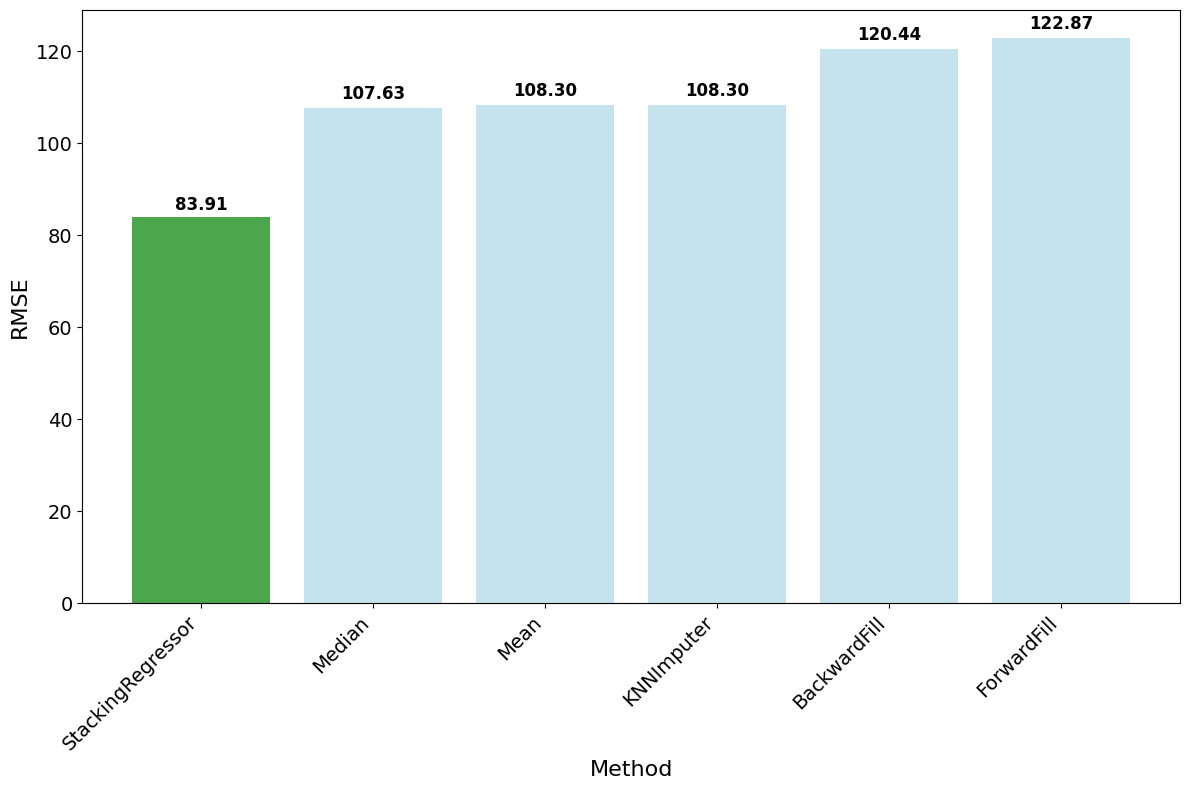

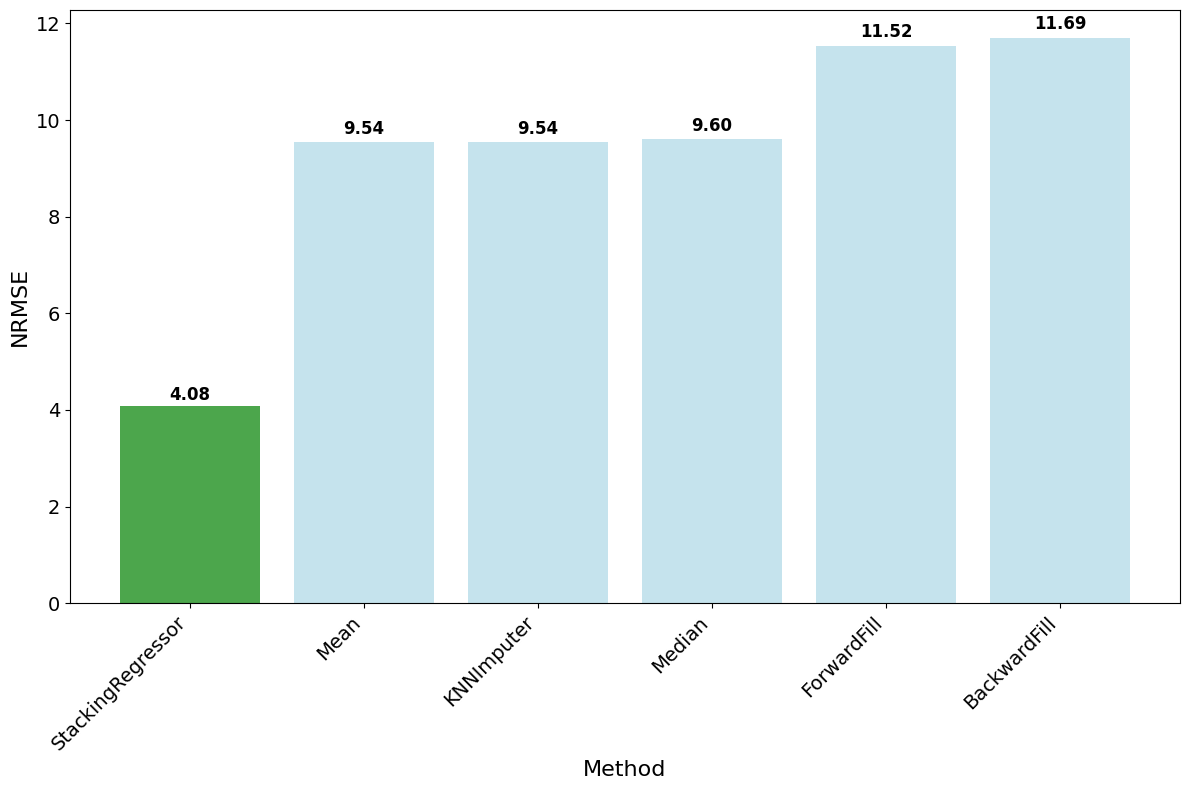

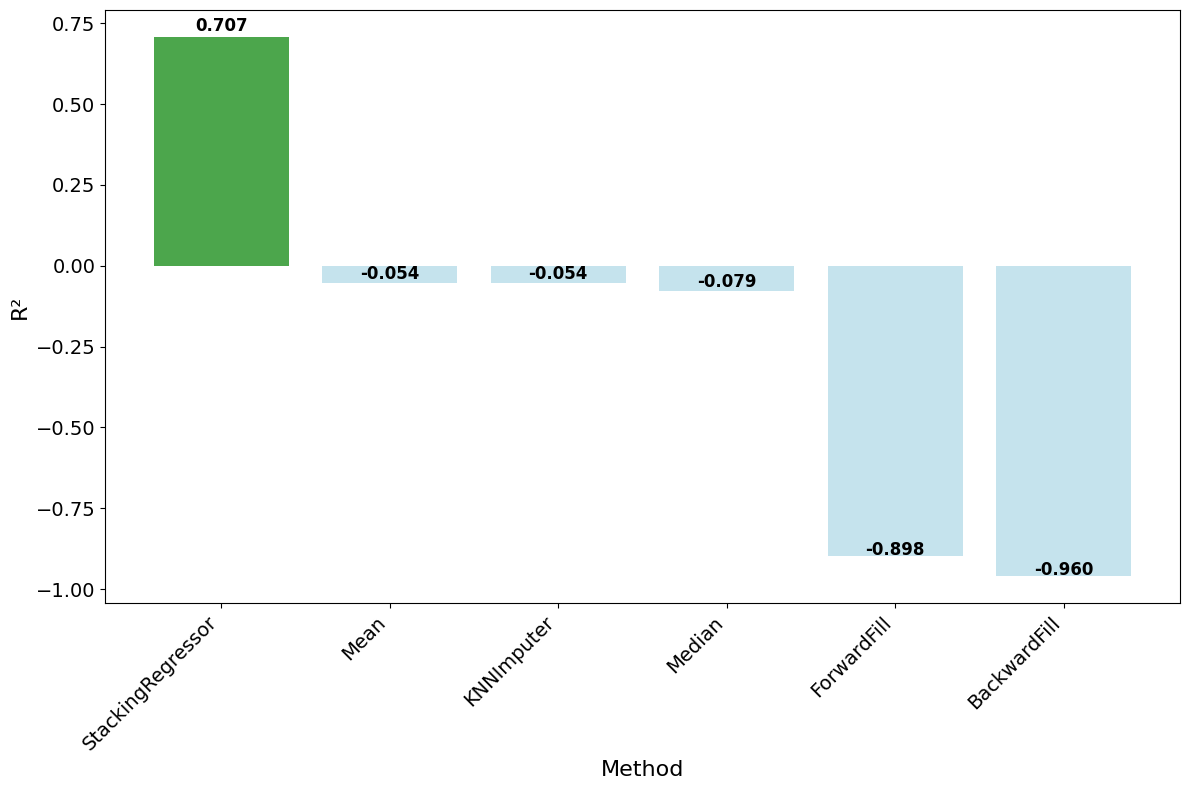

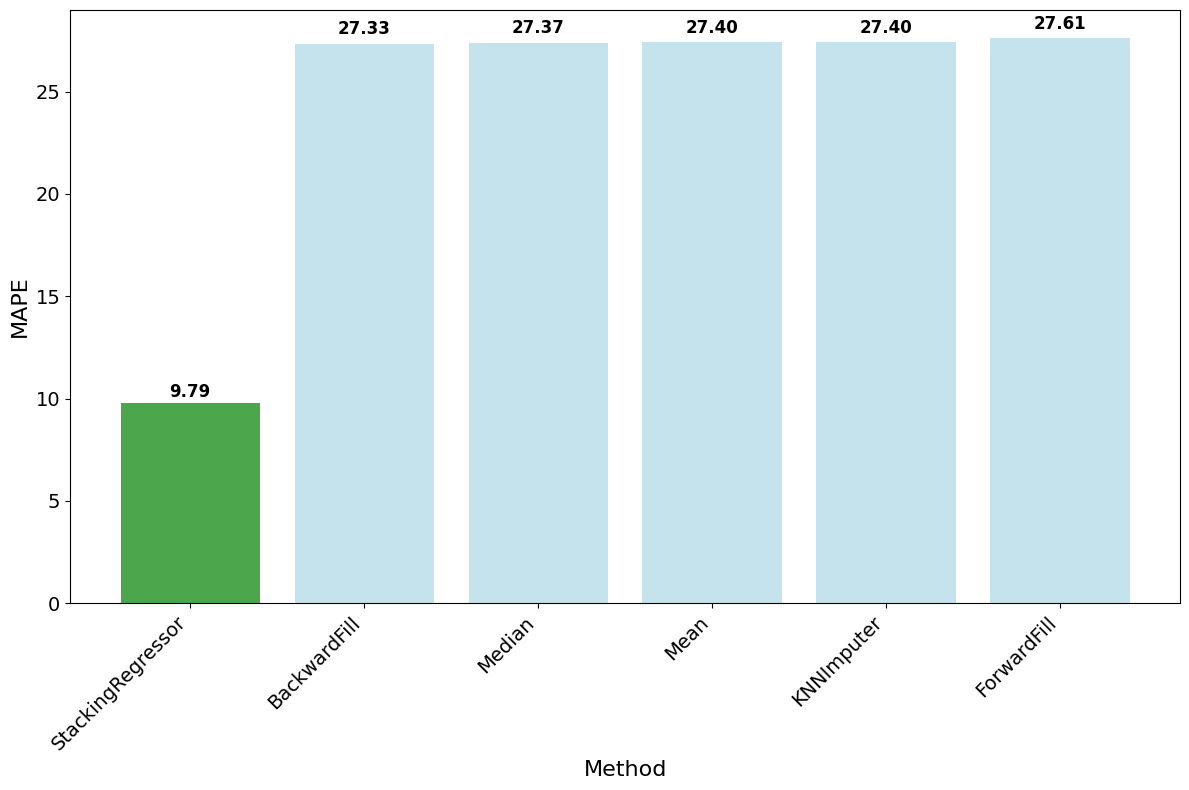


GENERATING SEPARATE MISSING RATE EVOLUTION PLOTS...


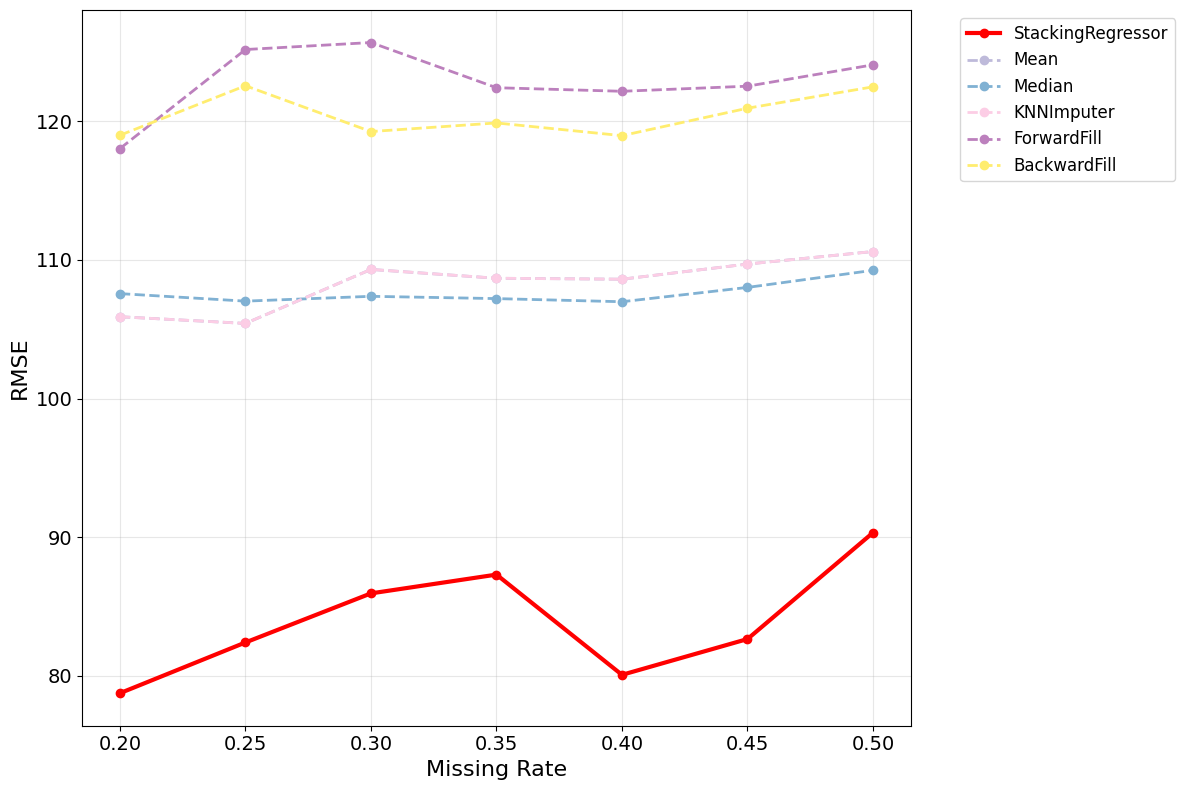

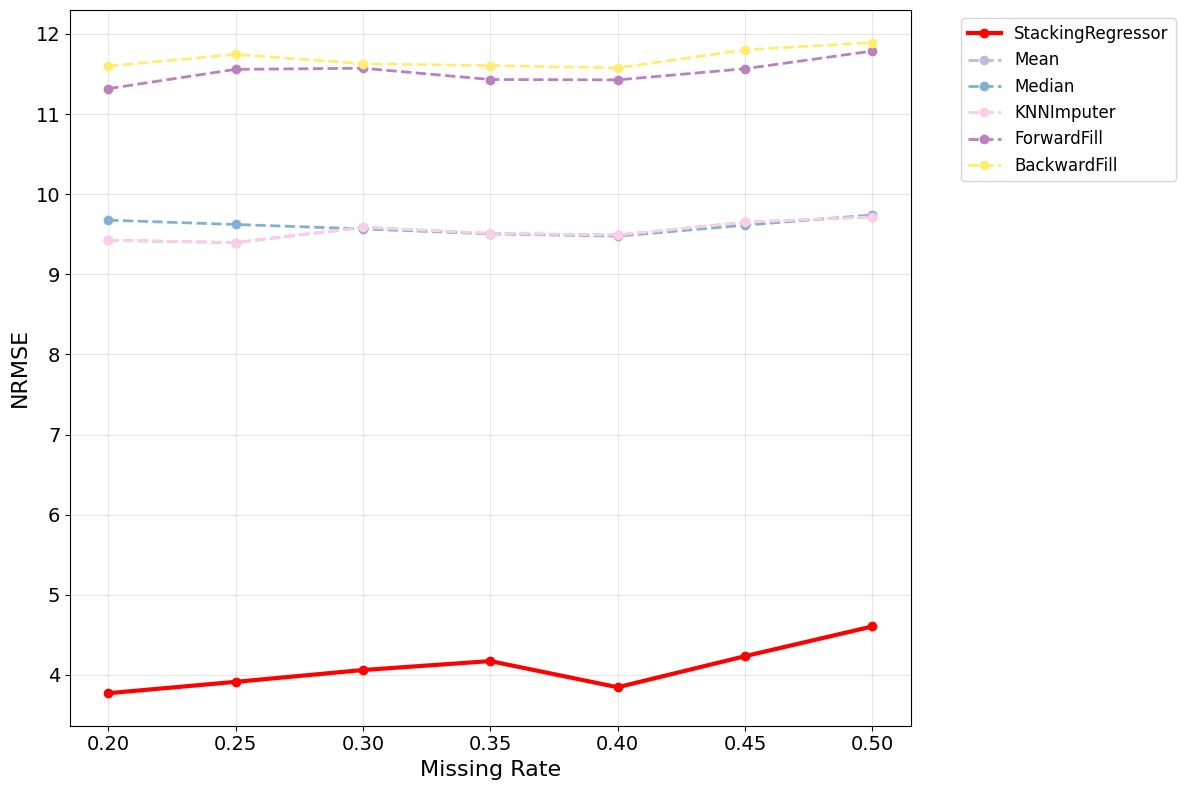

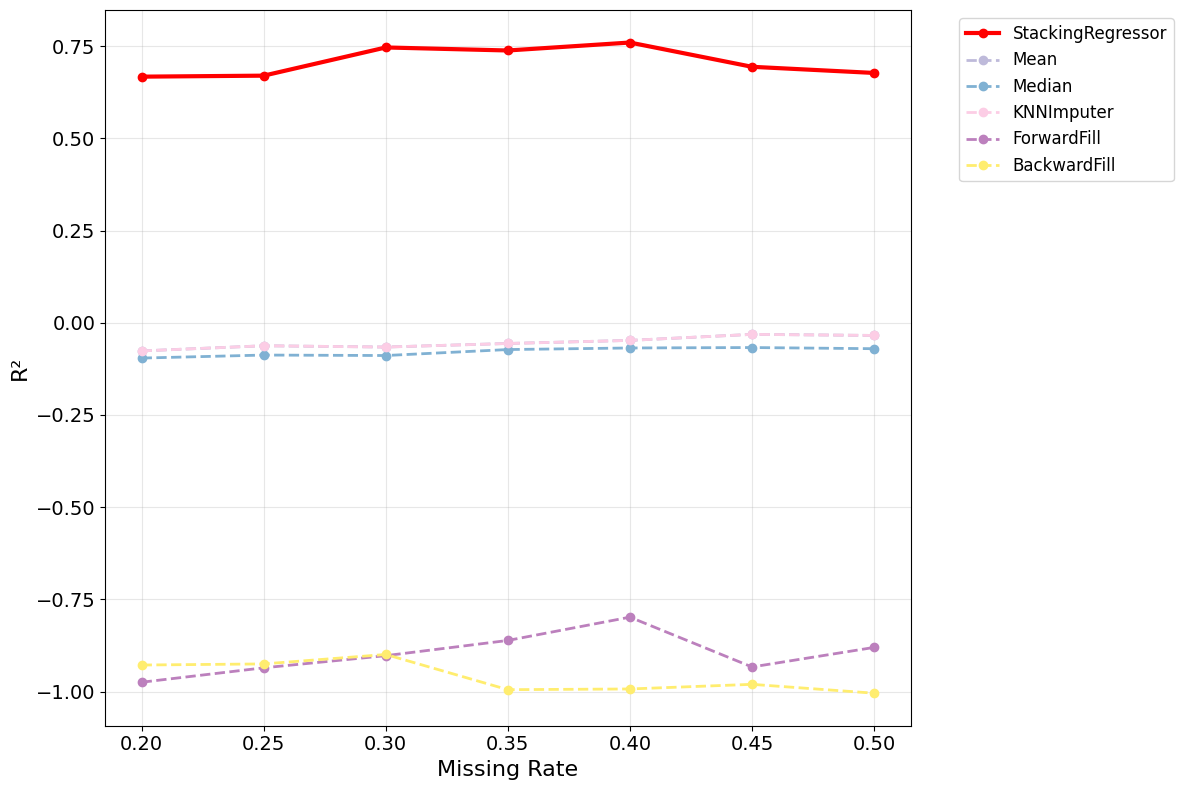

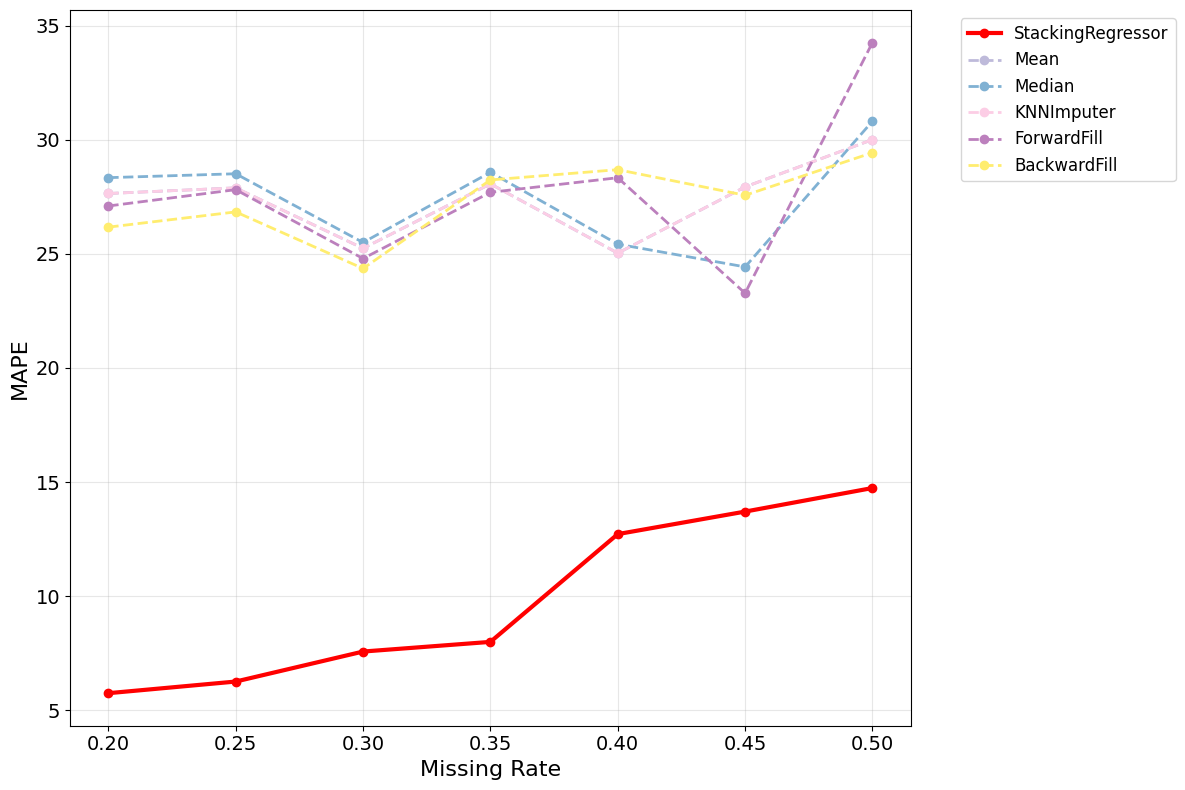


GENERATING SEPARATE BOXPLOTS...


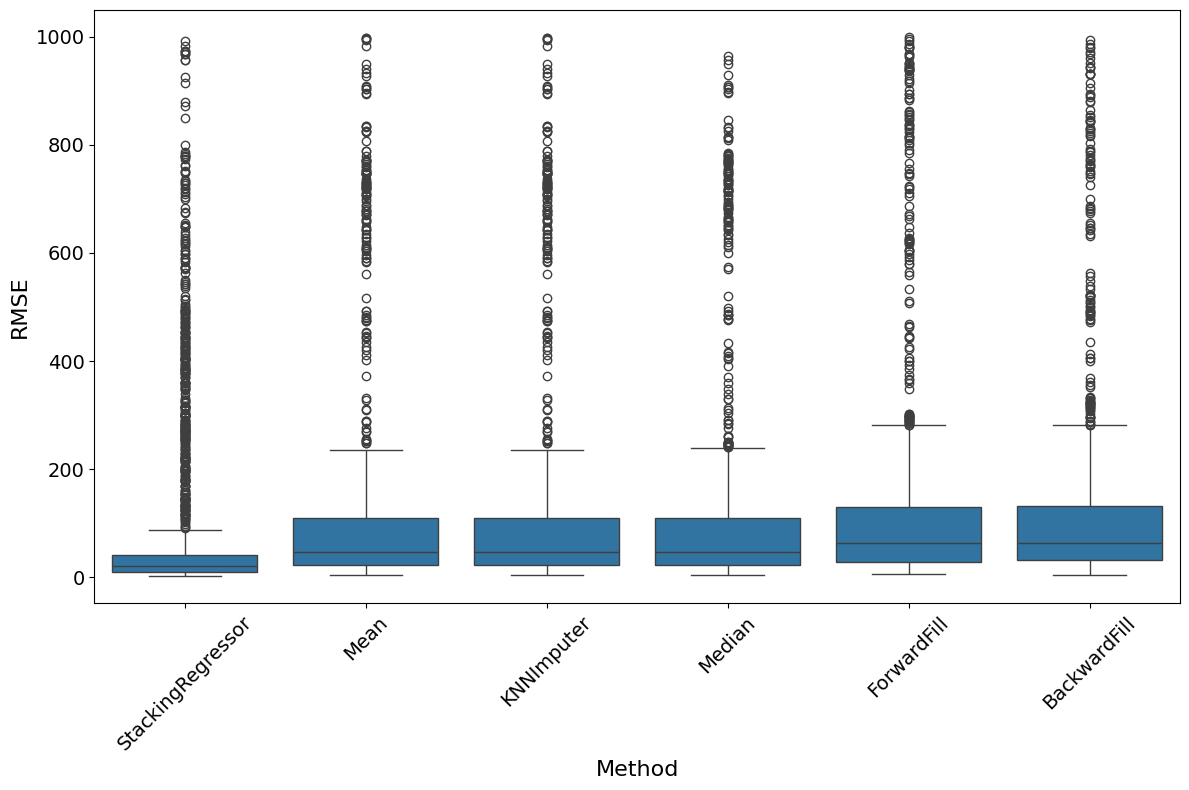

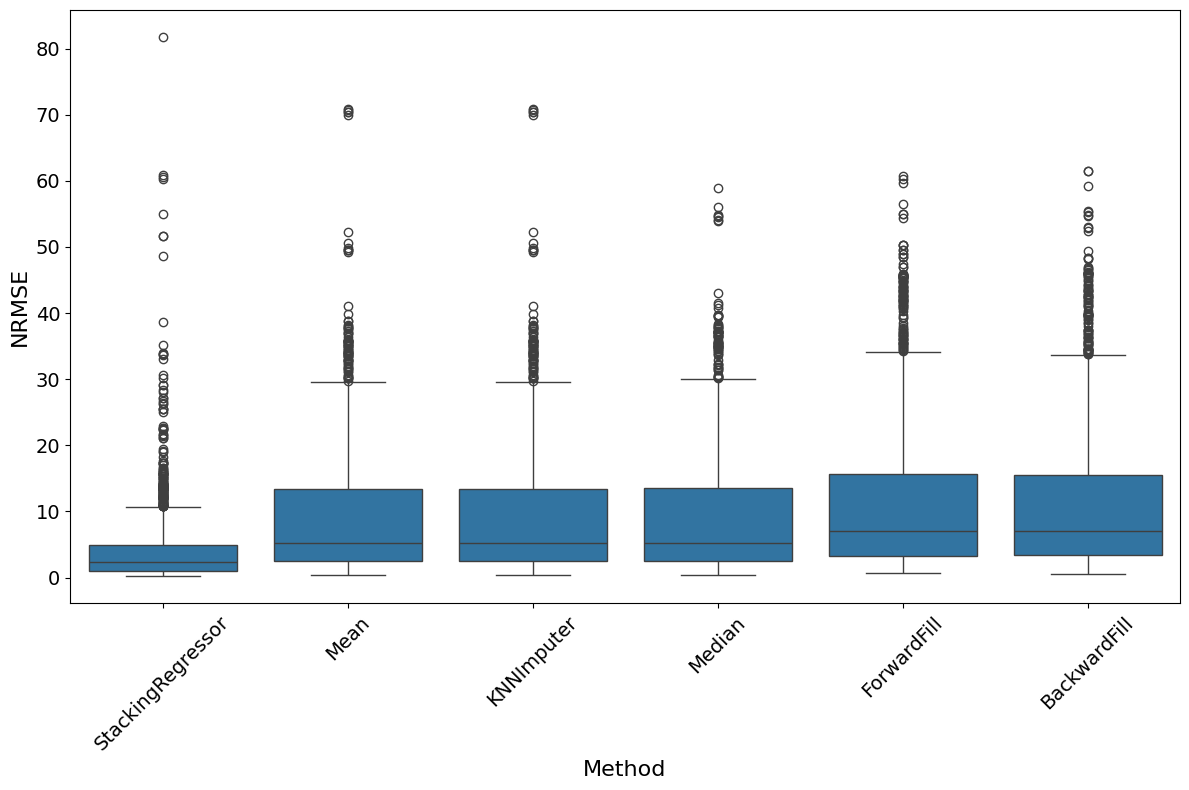

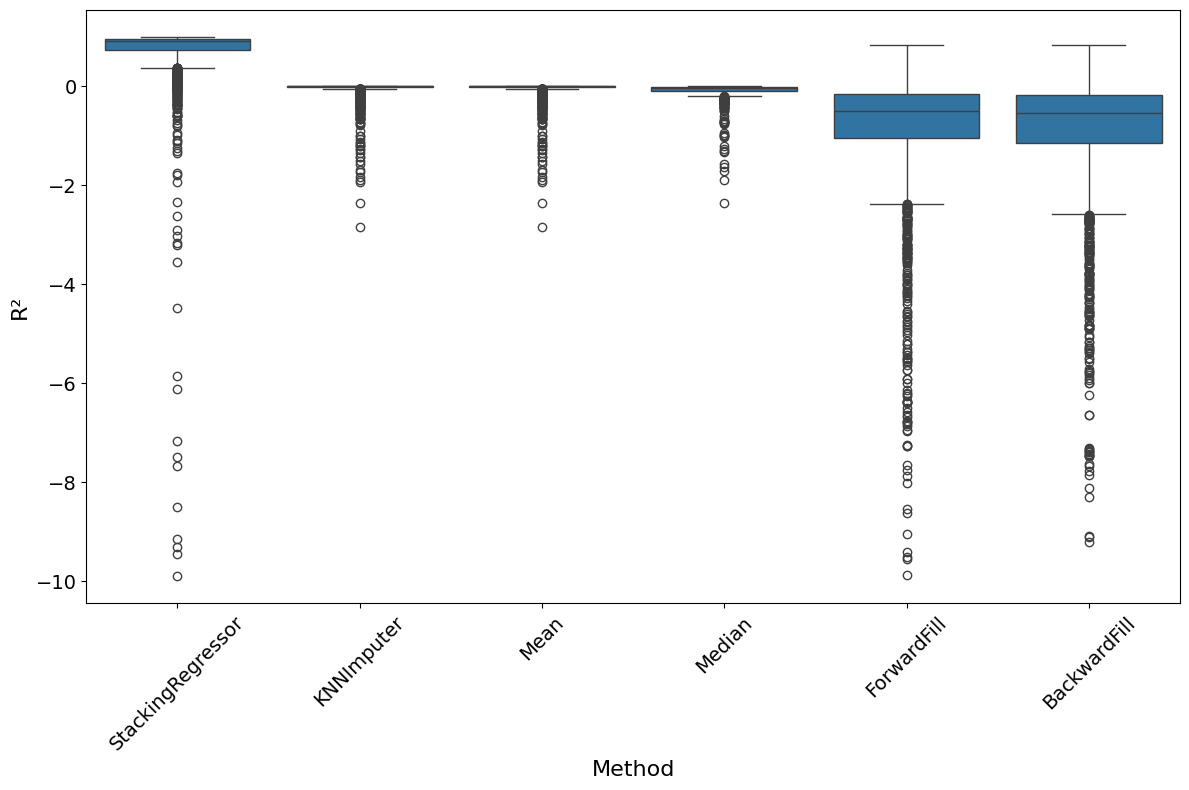

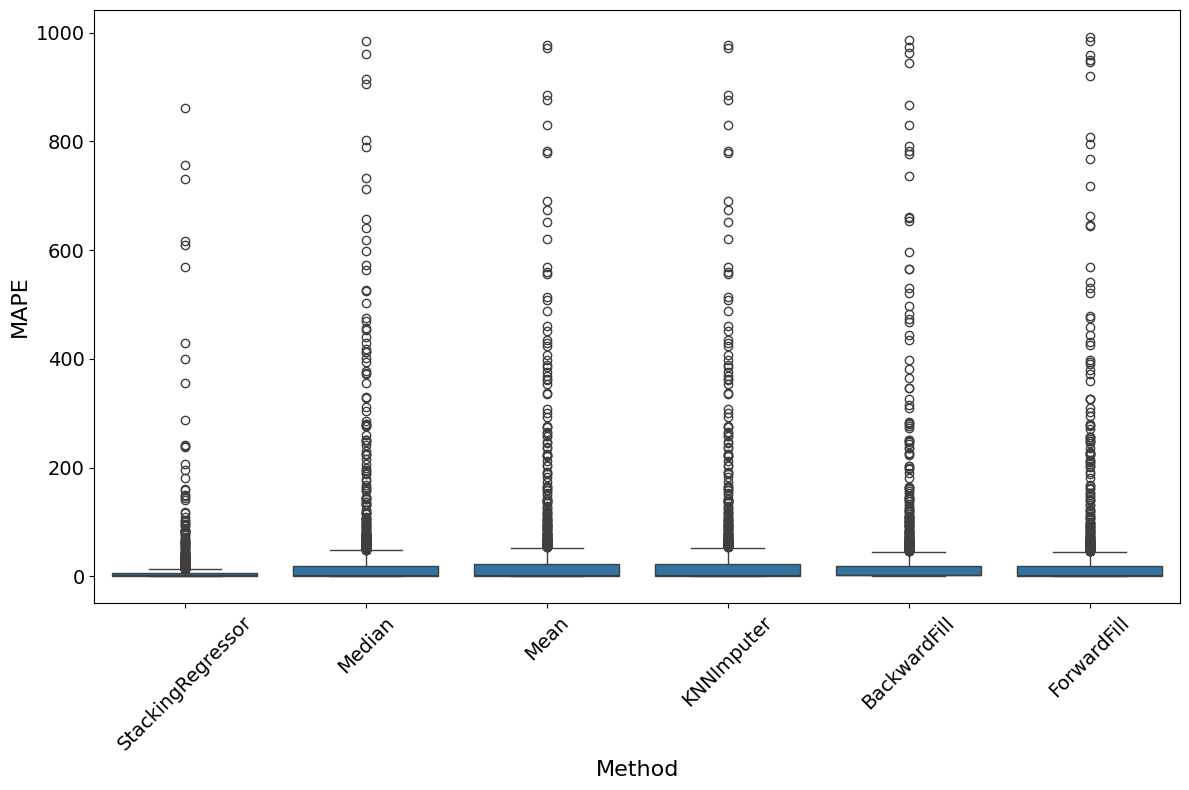


SUMMARY FOR SCIENTIFIC PAPER

EXPERIMENTAL METHODOLOGY:
   Unique data sources: 290
   Duplicate links removed: 287
   Compared methods: 6
   Valid configurations analyzed: 14001

BEST BASELINE: Mean

DETAILED STATISTICAL COMPARISON:

RMSE: 83.91 vs 108.30 (22.5% better)
NRMSE: 4.08 vs 9.54 (57.2% better)
R2: 0.707 vs -0.054 (0.761 points better)

SAVED FILES:
   - 'dados_limpos_links_unicos.csv'
   - 'estatisticas_links_unicos.csv'
   - 'links_selecionados_analise.txt' (complete list)

COMPARISON PLOTS:
   - 'comparacao_rmse.png'
   - 'comparacao_nrmse.png'
   - 'comparacao_r2.png'
   - 'comparacao_mape.png'

EVOLUTION PLOTS:
   - 'evolucao_rmse.png'
   - 'evolucao_nrmse.png'
   - 'evolucao_r2.png'
   - 'evolucao_mape.png'

BOXPLOTS:
   - 'boxplot_rmse.png'
   - 'boxplot_nrmse.png'
   - 'boxplot_r2.png'
   - 'boxplot_mape.png'
Total valid records: 14001


In [1]:

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Configurações de fonte parametrizáveis
FONT_CONFIG = {
    'method_names': 14,      # Tamanho da fonte para nomes dos métodos
    'axis_labels': 16,       # Tamanho da fonte para labels dos eixos
    'axis_values': 14,       # Tamanho da fonte para valores dos eixos
    'bar_values': 12,        # Tamanho da fonte para valores nas barras
    'legend': 12,            # Tamanho da fonte para legenda
    'title': 18              # Tamanho da fonte para títulos (se necessário)
}

def identificar_links_duplicados(data):
    """
    Identifica links duplicados (ex: ac-am e am-ac) e seleciona o melhor
    baseado no critério: melhor NRMSE do Stacking, depois melhor R²
    """
    print("IDENTIFYING AND SELECTING UNIQUE LINKS...")
    print("=" * 60)
    
    # Criar dicionário para agrupar links duplicados
    links_agrupados = {}
    
    for link in data.keys():
        # Criar chave normalizada (ordenar os nós)
        nodes = link.split('-')
        key = '-'.join(sorted(nodes))
        
        if key not in links_agrupados:
            links_agrupados[key] = []
        links_agrupados[key].append(link)
    
    # Identificar links com duplicatas
    links_duplicados = {k: v for k, v in links_agrupados.items() if len(v) > 1}
    links_unicos = {k: v[0] for k, v in links_agrupados.items() if len(v) == 1}
    
    print(f"LINK STATISTICS:")
    print(f"   Total original links: {len(data)}")
    print(f"   Unique link groups: {len(links_agrupados)}")
    print(f"   Links with duplicates: {len(links_duplicados)}")
    print(f"   Unique links: {len(links_unicos)}")
    
    # Selecionar o melhor link de cada grupo duplicado
    links_selecionados = {}
    
    for grupo, links in links_duplicados.items():
        print(f"\nGROUP {grupo}: {links}")
        
        melhor_link = None
        melhor_nrmse = float('inf')
        melhor_r2 = -float('inf')
        
        for link in links:
            # Calcular média do NRMSE e R² do Stacking para este link
            nrmse_values = []
            r2_values = []
            
            for missing_rate, methods in data[link].items():
                stacking_metrics = methods['stacking']['mean']['StackingRegressor']
                if stacking_metrics['nrmse'] is not None:
                    nrmse_values.append(stacking_metrics['nrmse'])
                if stacking_metrics['r2'] is not None:
                    r2_values.append(stacking_metrics['r2'])
            
            if nrmse_values and r2_values:
                avg_nrmse = np.mean(nrmse_values)
                avg_r2 = np.mean(r2_values)
                
                print(f"   {link}: NRMSE={avg_nrmse:.2f}, R2={avg_r2:.3f}")
                
                # Critério de seleção: primeiro NRMSE, depois R²
                if (avg_nrmse < melhor_nrmse) or (avg_nrmse == melhor_nrmse and avg_r2 > melhor_r2):
                    melhor_link = link
                    melhor_nrmse = avg_nrmse
                    melhor_r2 = avg_r2
        
        if melhor_link:
            links_selecionados[grupo] = melhor_link
            print(f"   SELECTED: {melhor_link} (NRMSE: {melhor_nrmse:.2f}, R2: {melhor_r2:.3f})")
        else:
            # Se nenhum tem métricas válidas, seleciona o primeiro
            links_selecionados[grupo] = links[0]
            print(f"   SELECTED: {links[0]} (no valid metrics)")
    
    # Adicionar links únicos
    for grupo, link in links_unicos.items():
        links_selecionados[grupo] = link
    
    # Criar novo dicionário com dados filtrados
    data_filtrado = {}
    for grupo, link in links_selecionados.items():
        data_filtrado[link] = data[link]
    
    print(f"\nSELECTION RESULT:")
    print(f"   Original links: {len(data)}")
    print(f"   Links after filter: {len(data_filtrado)}")
    print(f"   Reduction: {len(data) - len(data_filtrado)} links removed")
    
    # Salvar lista de links selecionados
    with open('links_selecionados_analise.txt', 'w', encoding='utf-8') as f:
        f.write("SELECTED LINKS FOR FINAL ANALYSIS\n")
        f.write("=" * 50 + "\n")
        f.write(f"Total: {len(data_filtrado)} links\n\n")
        
        # Escrever grupos com duplicatas
        if links_duplicados:
            f.write("GROUPS WITH DUPLICATES (only selected):\n")
            for grupo, links in links_duplicados.items():
                selecionado = links_selecionados[grupo]
                f.write(f"  {grupo}:\n")
                for link in links:
                    if link == selecionado:
                        f.write(f"    [SELECTED] {link}\n")
                    else:
                        f.write(f"    [REMOVED]  {link}\n")
                f.write("\n")
        
        # Escrever links únicos
        f.write("UNIQUE LINKS:\n")
        for grupo, link in links_unicos.items():
            f.write(f"  [UNIQUE] {link}\n")
    
    return data_filtrado, links_selecionados

def print_missing_evolution_tables(df_clean, metodos_selecionados):
    """Print evolution data by missing rate in table format for Overleaf"""
    print("\n" + "=" * 80)
    print("MISSING RATE EVOLUTION DATA FOR TABLES")
    print("=" * 80)
    
    # Get unique missing rates sorted
    missing_rates = sorted(df_clean['missing_rate'].unique())
    
    print(f"\nDETECTED MISSING RATES: {missing_rates}")
    print(f"Total unique rates: {len(missing_rates)}")
    
    # Métricas para análise
    metrics = ['rmse', 'nrmse', 'r2', 'mape']
    metric_names = {'rmse': 'RMSE', 'nrmse': 'NRMSE', 'r2': 'R²', 'mape': 'MAPE'}
    
    for metric in metrics:
        print(f"\n{metric_names[metric]} EVOLUTION BY MISSING RATE:")
        print("-" * 80)
        
        # Create table header
        header = "Missing Rate | " + " | ".join([f"{method:>15}" for method in metodos_selecionados])
        print(header)
        print("-" * len(header))
        
        # AGRUPAR PRIMEIRO - cria uma tabela pivô com missing_rate x method
        pivot_data = df_clean.groupby(['missing_rate', 'method'])[metric].mean().unstack(fill_value=np.nan)
        
        # Garantir que todos os métodos estão presentes
        for method in metodos_selecionados:
            if method not in pivot_data.columns:
                pivot_data[method] = np.nan
        
        # Ordenar colunas conforme metodos_selecionados
        pivot_data = pivot_data[metodos_selecionados]
        
        # Imprimir cada linha (uma por missing rate)
        for rate in missing_rates:
            if rate in pivot_data.index:
                row_values = []
                for method in metodos_selecionados:
                    value = pivot_data.loc[rate, method]
                    if pd.notna(value):
                        if metric == 'r2':
                            row_values.append(f"{value:>15.3f}")
                        elif metric == 'mape':
                            row_values.append(f"{value:>15.1f}")
                        else:
                            row_values.append(f"{value:>15.2f}")
                    else:
                        row_values.append(f"{'N/A':>15}")
                
                print(f"{rate:>11.2f} | " + " | ".join(row_values))
            
def plot_comparison_final_separado(df_clean, metodos_selecionados):
    """Plot separado: Comparação final entre métodos - UMA FIGURA POR MÉTRICA"""
    print("\nGENERATING SEPARATE COMPARISON PLOTS...")
    
    comparison_data = []
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            comparison_data.append({
                'method': method,
                'rmse': method_data['rmse'].mean(),
                'nrmse': method_data['nrmse'].mean(),
                'r2': method_data['r2'].mean(),
                'mape': method_data['mape'].mean()
            })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Plot RMSE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    sorted_df = comp_df.sort_values('rmse', ascending=True)
    colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
    bars = plt.bar(range(len(sorted_df)), sorted_df['rmse'], color=colors, alpha=0.7)
    plt.ylabel('RMSE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(range(len(sorted_df)), sorted_df['method'], rotation=45, ha='right', 
               fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    for bar, value in zip(bars, sorted_df['rmse']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                f'{value:.2f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=FONT_CONFIG['bar_values'])
    
    plt.tight_layout()
    plt.savefig('comparacao_rmse.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot NRMSE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    sorted_df = comp_df.sort_values('nrmse', ascending=True)
    colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
    bars = plt.bar(range(len(sorted_df)), sorted_df['nrmse'], color=colors, alpha=0.7)
    plt.ylabel('NRMSE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(range(len(sorted_df)), sorted_df['method'], rotation=45, ha='right', 
               fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    for bar, value in zip(bars, sorted_df['nrmse']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                f'{value:.2f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=FONT_CONFIG['bar_values'])
    
    plt.tight_layout()
    plt.savefig('comparacao_nrmse.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot R2 - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    sorted_df = comp_df.sort_values('r2', ascending=False)
    colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
    bars = plt.bar(range(len(sorted_df)), sorted_df['r2'], color=colors, alpha=0.7)
    plt.ylabel('R²', fontsize=FONT_CONFIG['axis_labels'])
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(range(len(sorted_df)), sorted_df['method'], rotation=45, ha='right', 
               fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    for bar, value in zip(bars, sorted_df['r2']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=FONT_CONFIG['bar_values'])
    
    plt.tight_layout()
    plt.savefig('comparacao_r2.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot MAPE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    sorted_df = comp_df.sort_values('mape', ascending=True)
    colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
    bars = plt.bar(range(len(sorted_df)), sorted_df['mape'], color=colors, alpha=0.7)
    plt.ylabel('MAPE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(range(len(sorted_df)), sorted_df['method'], rotation=45, ha='right', 
               fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    for bar, value in zip(bars, sorted_df['mape']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                f'{value:.2f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=FONT_CONFIG['bar_values'])
    
    plt.tight_layout()
    plt.savefig('comparacao_mape.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_evolution_missing_separado(df_clean, metodos_selecionados):
    """Plot separado: Performance por taxa de missing - UMA FIGURA POR MÉTRICA"""
    print("\nGENERATING SEPARATE MISSING RATE EVOLUTION PLOTS...")
    
    # Cores distintas para cada método selecionado
    colors = plt.cm.Set3(np.linspace(0, 1, len(metodos_selecionados)))
    color_map = {method: color for method, color in zip(metodos_selecionados, colors)}
    
    # Plot RMSE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            performance_by_missing = method_data.groupby('missing_rate')['rmse'].mean().sort_index()
            
            # Usar cor vermelha para Stacking, outras cores para baselines
            color = 'red' if method == 'StackingRegressor' else color_map[method]
            linewidth = 3 if method == 'StackingRegressor' else 2
            linestyle = '-' if method == 'StackingRegressor' else '--'
            
            plt.plot(performance_by_missing.index, performance_by_missing.values, 
                    marker='o', linewidth=linewidth, label=method, 
                    markersize=6, color=color, linestyle=linestyle)
    
    plt.xlabel('Missing Rate', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('RMSE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(fontsize=FONT_CONFIG['axis_values'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=FONT_CONFIG['legend'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('evolucao_rmse.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot NRMSE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            performance_by_missing = method_data.groupby('missing_rate')['nrmse'].mean().sort_index()
            
            color = 'red' if method == 'StackingRegressor' else color_map[method]
            linewidth = 3 if method == 'StackingRegressor' else 2
            linestyle = '-' if method == 'StackingRegressor' else '--'
            
            plt.plot(performance_by_missing.index, performance_by_missing.values, 
                    marker='o', linewidth=linewidth, label=method, 
                    markersize=6, color=color, linestyle=linestyle)
    
    plt.xlabel('Missing Rate', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('NRMSE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(fontsize=FONT_CONFIG['axis_values'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=FONT_CONFIG['legend'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('evolucao_nrmse.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot R2 - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            performance_by_missing = method_data.groupby('missing_rate')['r2'].mean().sort_index()
            
            color = 'red' if method == 'StackingRegressor' else color_map[method]
            linewidth = 3 if method == 'StackingRegressor' else 2
            linestyle = '-' if method == 'StackingRegressor' else '--'
            
            plt.plot(performance_by_missing.index, performance_by_missing.values, 
                    marker='o', linewidth=linewidth, label=method, 
                    markersize=6, color=color, linestyle=linestyle)
    
    plt.xlabel('Missing Rate', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('R²', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(fontsize=FONT_CONFIG['axis_values'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=FONT_CONFIG['legend'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('evolucao_r2.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot MAPE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            performance_by_missing = method_data.groupby('missing_rate')['mape'].mean().sort_index()
            
            color = 'red' if method == 'StackingRegressor' else color_map[method]
            linewidth = 3 if method == 'StackingRegressor' else 2
            linestyle = '-' if method == 'StackingRegressor' else '--'
            
            plt.plot(performance_by_missing.index, performance_by_missing.values, 
                    marker='o', linewidth=linewidth, label=method, 
                    markersize=6, color=color, linestyle=linestyle)
    
    plt.xlabel('Missing Rate', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('MAPE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(fontsize=FONT_CONFIG['axis_values'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=FONT_CONFIG['legend'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('evolucao_mape.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_boxplot_comparison_separado(df_clean, metodos_selecionados):
    """Plot separado: Boxplot comparativo - UMA FIGURA POR MÉTRICA"""
    print("\nGENERATING SEPARATE BOXPLOTS...")
    
    # Filtrar apenas métodos selecionados
    df_selected = df_clean[df_clean['method'].isin(metodos_selecionados)]
    
    # Plot RMSE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    method_order = df_selected.groupby('method')['rmse'].median().sort_values().index
    sns.boxplot(data=df_selected, x='method', y='rmse', order=method_order)
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('RMSE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(rotation=45, fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    # Destacar Stacking
    ax = plt.gca()
    for i, artist in enumerate(ax.artists):
        if method_order[i] == 'StackingRegressor':
            artist.set_facecolor('lightgreen')
            artist.set_edgecolor('darkgreen')
            artist.set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('boxplot_rmse.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot NRMSE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    method_order = df_selected.groupby('method')['nrmse'].median().sort_values().index
    sns.boxplot(data=df_selected, x='method', y='nrmse', order=method_order)
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('NRMSE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(rotation=45, fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    # Destacar Stacking
    ax = plt.gca()
    for i, artist in enumerate(ax.artists):
        if method_order[i] == 'StackingRegressor':
            artist.set_facecolor('lightgreen')
            artist.set_edgecolor('darkgreen')
            artist.set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('boxplot_nrmse.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot R2 - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    method_order = df_selected.groupby('method')['r2'].median().sort_values(ascending=False).index
    sns.boxplot(data=df_selected, x='method', y='r2', order=method_order)
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('R²', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(rotation=45, fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    # Destacar Stacking
    ax = plt.gca()
    for i, artist in enumerate(ax.artists):
        if method_order[i] == 'StackingRegressor':
            artist.set_facecolor('lightgreen')
            artist.set_edgecolor('darkgreen')
            artist.set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('boxplot_r2.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot MAPE - SEPARATE FIGURE
    plt.figure(figsize=(12, 8))
    method_order = df_selected.groupby('method')['mape'].median().sort_values().index
    sns.boxplot(data=df_selected, x='method', y='mape', order=method_order)
    plt.xlabel('Method', fontsize=FONT_CONFIG['axis_labels'])
    plt.ylabel('MAPE', fontsize=FONT_CONFIG['axis_labels'])
    plt.xticks(rotation=45, fontsize=FONT_CONFIG['method_names'])
    plt.yticks(fontsize=FONT_CONFIG['axis_values'])
    
    # Destacar Stacking
    ax = plt.gca()
    for i, artist in enumerate(ax.artists):
        if method_order[i] == 'StackingRegressor':
            artist.set_facecolor('lightgreen')
            artist.set_edgecolor('darkgreen')
            artist.set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('boxplot_mape.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def final_robust_analysis(json_file_path):
    """Final robust analysis - removing extreme outliers and selecting unique links"""
    
    # Carregar dados
    with open(json_file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # FASE 1: SELECIONAR LINKS ÚNICOS
    data_filtrado, links_selecionados = identificar_links_duplicados(data)
    
    # FASE 2: PROCESSAR DADOS COM LINKS SELECIONADOS
    records = []
    all_sources = set()
    
    for link, missing_data in data_filtrado.items():
        all_sources.add(link)
        for missing_rate, methods in missing_data.items():
            missing_rate_float = float(missing_rate)
            
            for method_name, metrics in methods['baseline'].items():
                records.append({
                    'link': link, 'missing_rate': missing_rate_float,
                    'method_type': 'baseline', 'method': method_name,
                    'rmse': metrics['rmse'], 'nrmse': metrics['nrmse'],
                    'r2': metrics['r2'], 'mape': metrics['mape']
                })
            
            stacking_metrics = methods['stacking']['mean']['StackingRegressor']
            records.append({
                'link': link, 'missing_rate': missing_rate_float,
                'method_type': 'stacking', 'method': 'StackingRegressor',
                'rmse': stacking_metrics['rmse'], 'nrmse': stacking_metrics['nrmse'],
                'r2': stacking_metrics['r2'], 'mape': stacking_metrics['mape']
            })
    
    df = pd.DataFrame(records)
    
    print("\nFINAL ROBUST ANALYSIS - RELIABLE RESULTS")
    print("=" * 80)
    
    # ESTATÍSTICAS INICIAIS DO DATASET
    print(f"\nDATASET STATISTICS (AFTER FILTERING):")
    print(f"   Unique data sources: {len(all_sources)}")
    print(f"   Total configurations (before cleaning): {len(df)}")
    print(f"   Compared methods: {len(df['method'].unique())}")
    print(f"   Tested missing rates: {sorted(df['missing_rate'].unique())}")
    
    # REMOVER OUTLIERS EXTREMOS
    print("\nFILTERING EXTREME OUTLIERS...")
    
    df_clean = df.copy()
    
    # Critérios de outliers
    mape_threshold = 1000
    r2_threshold = -10
    rmse_threshold = 1000
    
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['mape'] <= mape_threshold]
    df_clean = df_clean[df_clean['r2'] >= r2_threshold]
    df_clean = df_clean[df_clean['rmse'] <= rmse_threshold]
    
    removed_count = initial_count - len(df_clean)
    print(f"Removed {removed_count} problematic records ({removed_count/initial_count*100:.1f}%)")
    
    # ESTATÍSTICAS FINAIS COMPLETAS
    print("\nFINAL COMPLETE STATISTICS (Clean Data):")
    print("-" * 60)
    
    metrics = ['rmse', 'nrmse', 'r2', 'mape']
    summary_data = []
    
    for method in df_clean['method'].unique():
        method_data = df_clean[df_clean['method'] == method]
        row = {'method': method, 'count': len(method_data)}
        
        for metric in metrics:
            values = method_data[metric]
            row[f'{metric}_mean'] = values.mean()
            row[f'{metric}_std'] = values.std()
            row[f'{metric}_median'] = values.median()
            row[f'{metric}_min'] = values.min()
            row[f'{metric}_max'] = values.max()
            row[f'{metric}_q1'] = values.quantile(0.25)
            row[f'{metric}_q3'] = values.quantile(0.75)
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calcular ranking por métrica
    for metric in metrics:
        if metric == 'r2':
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=False)
        else:
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=True)
    
    # Ranking geral
    rank_columns = [f'{metric}_rank' for metric in metrics]
    summary_df['overall_rank'] = summary_df[rank_columns].mean(axis=1)
    summary_df = summary_df.sort_values('overall_rank')
    
    print("\n" + "=" * 80)
    print("FINAL RANKING - CLEAN DATA")
    print("=" * 80)
    
    for i, (_, row) in enumerate(summary_df.iterrows(), 1):
        print(f"{i:2d}. {row['method']:20s} | "
              f"RMSE: {row['rmse_mean']:6.2f} | "
              f"NRMSE: {row['nrmse_mean']:5.2f} | "
              f"R2: {row['r2_mean']:6.3f} | "
              f"MAPE: {row['mape_mean']:6.2f}%")
    
    # ANÁLISE POR LINK (para verificar performance individual)
    print("\n" + "=" * 80)
    print("STACKING PERFORMANCE BY LINK")
    print("=" * 80)
    
    link_performance = []
    for link in sorted(all_sources):
        link_data = df_clean[df_clean['link'] == link]
        stacking_data = link_data[link_data['method'] == 'StackingRegressor']
        
        if len(stacking_data) > 0:
            avg_nrmse = stacking_data['nrmse'].mean()
            avg_r2 = stacking_data['r2'].mean()
            link_performance.append({
                'link': link,
                'nrmse': avg_nrmse,
                'r2': avg_r2,
                'samples': len(stacking_data)
            })
    
    # Ordenar por NRMSE (menor é melhor)
    link_performance.sort(key=lambda x: x['nrmse'])
    
    print("\nTop 10 best links by Stacking NRMSE:")
    print("Link      | NRMSE  |   R2   | Samples")
    print("-" * 40)
    for perf in link_performance[:10]:
        print(f"{perf['link']:9} | {perf['nrmse']:6.2f} | {perf['r2']:6.3f} | {perf['samples']:8}")
    
    print(f"\nCOMPLETE LIST OF SELECTED LINKS:")
    print(f"   Saved in: 'links_selecionados_analise.txt'")
    print(f"   Total links in analysis: {len(all_sources)}")
    
    # GRÁFICOS FINAIS SEPARADOS - UMA FIGURA POR GRÁFICO
    metodos_selecionados = ['StackingRegressor', 'Mean', 'Median', 'KNNImputer', 'ForwardFill', 'BackwardFill']
    
    # PRINT EVOLUTION DATA FOR TABLES
    print_missing_evolution_tables(df_clean, metodos_selecionados)
    
    # Chamar funções de plot separadas - CADA UMA GERA FIGURAS INDIVIDUAIS
    plot_comparison_final_separado(df_clean, metodos_selecionados)
    plot_evolution_missing_separado(df_clean, metodos_selecionados)
    plot_boxplot_comparison_separado(df_clean, metodos_selecionados)
    
    # RESUMO FINAL
    print("\n" + "=" * 80)
    print("SUMMARY FOR SCIENTIFIC PAPER")
    print("=" * 80)
    
    stacking_data = df_clean[df_clean['method'] == 'StackingRegressor']
    best_baseline_data = df_clean[df_clean['method'] == summary_df.iloc[1]['method']]
    
    print(f"\nEXPERIMENTAL METHODOLOGY:")
    print(f"   Unique data sources: {len(all_sources)}")
    print(f"   Duplicate links removed: {len(data) - len(data_filtrado)}")
    print(f"   Compared methods: {len(metodos_selecionados)}")
    print(f"   Valid configurations analyzed: {len(df_clean)}")
    
    print(f"\nBEST BASELINE: {summary_df.iloc[1]['method']}")
    
    print(f"\nDETAILED STATISTICAL COMPARISON:")
    print(f"\nRMSE: {stacking_data['rmse'].mean():.2f} vs {best_baseline_data['rmse'].mean():.2f} ({(1 - stacking_data['rmse'].mean()/best_baseline_data['rmse'].mean())*100:.1f}% better)")
    print(f"NRMSE: {stacking_data['nrmse'].mean():.2f} vs {best_baseline_data['nrmse'].mean():.2f} ({(1 - stacking_data['nrmse'].mean()/best_baseline_data['nrmse'].mean())*100:.1f}% better)")
    print(f"R2: {stacking_data['r2'].mean():.3f} vs {best_baseline_data['r2'].mean():.3f} ({(stacking_data['r2'].mean() - best_baseline_data['r2'].mean()):.3f} points better)")
    
    # Salvar dados finais
    df_clean.to_csv('dados_limpos_links_unicos.csv', index=False)
    summary_df.to_csv('estatisticas_links_unicos.csv', index=False)
    
    print(f"\nSAVED FILES:")
    print(f"   - 'dados_limpos_links_unicos.csv'")
    print(f"   - 'estatisticas_links_unicos.csv'")
    print(f"   - 'links_selecionados_analise.txt' (complete list)")
    print(f"\nCOMPARISON PLOTS:")
    print(f"   - 'comparacao_rmse.png'")
    print(f"   - 'comparacao_nrmse.png'")
    print(f"   - 'comparacao_r2.png'")
    print(f"   - 'comparacao_mape.png'")
    print(f"\nEVOLUTION PLOTS:")
    print(f"   - 'evolucao_rmse.png'")
    print(f"   - 'evolucao_nrmse.png'")
    print(f"   - 'evolucao_r2.png'")
    print(f"   - 'evolucao_mape.png'")
    print(f"\nBOXPLOTS:")
    print(f"   - 'boxplot_rmse.png'")
    print(f"   - 'boxplot_nrmse.png'")
    print(f"   - 'boxplot_r2.png'")
    print(f"   - 'boxplot_mape.png'")
    print(f"Total valid records: {len(df_clean)}")

# Executar análise final
json_file_path = "../../results/metrics_summary_final.json"
final_robust_analysis(json_file_path)

### Aqui eu filtro apenas os links bons pro stacking com base nos missing 0.2, 0.3, 0.4 e 0.5

In [ ]:
import json

# Caminho do arquivo JSON
json_path = "../../results/"  # ⬅️ coloque aqui o caminho do seu JSON

# Carregar o arquivo JSON
with open(json_path, 'r') as f:
    data = json.load(f)

def filter_superior_stacking(data):
    filtered_results = {}
    
    # Métricas de baseline para comparar
    baseline_methods = ["Mean", "Median", "KNNImputer", "ForwardFill", "BackwardFill", "RollingMean", "LinearInterpolation"]
    
    for location, percentages in data.items():
        location_results = {}
        all_percentages_valid = True
        
        # Verificar todas as porcentagens para esta localização
        for percentage, methods in percentages.items():
            if percentage not in ["0.2", "0.25", "0.3", "0.35", "0.4", "0.45", "0.5"]:
                continue
                
            # Verificar se existe stacking
            if "stacking" not in methods or "mean" not in methods["stacking"]:
                all_percentages_valid = False
                break
                
            stacking_data = methods["stacking"]["mean"]["StackingRegressor"]
            
            # Critério 1: R2 > 0.3
            if stacking_data["r2"] <= 0.3:
                all_percentages_valid = False
                break
            
            # Critério 2: Stacking superior a TODAS as baselines
            stacking_rmse = stacking_data["rmse"]
            
            baseline_valid = True
            for baseline_method in baseline_methods:
                if baseline_method in methods["baseline"]:
                    baseline_rmse = methods["baseline"][baseline_method]["rmse"]
                    # Stacking é melhor se tiver RMSE menor
                    if stacking_rmse >= baseline_rmse:
                        baseline_valid = False
                        break
            
            if not baseline_valid:
                all_percentages_valid = False
                break
                
            # Se passou nos critérios para esta porcentagem, adiciona aos resultados
            location_results[percentage] = methods
        
        # Se todas as porcentagens foram válidas, adiciona a localização aos resultados filtrados
        if all_percentages_valid and location_results:
            filtered_results[location] = location_results
    
    return filtered_results

# Aplicar o filtro
filtered_data = filter_superior_stacking(data)

# Criar JSON com os resultados filtrados
result_json = json.dumps(filtered_data, indent=4)
print(result_json)

# Salvar em arquivo
output_path = "resultados_filtrados.json"
with open(output_path, 'w') as f:
    json.dump(filtered_data, f, indent=4)

print(f"\n✅ Foram encontradas {len(filtered_data)} localizações que atendem aos critérios:")
for location in filtered_data.keys():
    print(f"- {location}")
print(f"\nArquivo salvo em: {output_path}")
